# 🔍 ML Fraud Detection Comprehensive Comparison

**신용카드 사기 탐지를 위한 6가지 머신러닝 접근법 성능 비교 연구**

---

## 📊 실험 개요

본 연구는 **동일한 데이터셋**과 **통일된 평가 기준**을 사용하여 다음 6가지 머신러닝 방법론의 사기 탐지 성능을 공정하게 비교합니다:

### 🏛️ Classical Methods
1. **Random Forest**: 특성 재구성 기반 이상탐지
2. **IsolationForest**: 비지도 이상탐지

### 🧠 Deep Learning Methods  
3. **CNN**: 1D Convolutional Neural Network 기반 재구성 이상탐지
4. **Classical Autoencoder**: 전통적 신경망 오토인코더

### ⚛️ Quantum Machine Learning Methods
5. **Quantum Autoencoder**: 각도 임베딩 기반 양자 오토인코더
6. **Enhanced qVAE**: 고급 양자 변분 오토인코더 (데이터 재업로딩, SWAP 테스트 포함)

---

## 🛠️ 실험 설계

### 데이터 전처리 (통일된 전처리 파이프라인)
- ✅ **표준화**: Time, Amount 컬럼 StandardScaler 적용
- ✅ **데이터 정제**: 결측치 및 중복 제거  
- ✅ **클래스 균형**: RandomUnderSampler 적용 (정상:사기 = 1:1)
- ✅ **데이터 셔플링**: 편향 방지를 위한 무작위 순서

### 하이퍼파라미터 최적화
- **튜닝 전략**: 비양자 방법은 랜덤 서치 10회 반복으로 통일, 양자 방법은 각자 5개씩 미리 정의된 전용 조합
- **G-Mean 최적화**: 불균형 데이터에 적합한 평가 지표 사용

### 평가 지표
- **AUC-ROC**: 전체적인 분류 성능
- **G-Mean**: 민감도와 특이도의 기하평균 (불균형 데이터 최적화)
- **F1-Score**: 정밀도와 재현율의 조화평균
- **정확도, 정밀도, 재현율**: 기본 분류 성능 지표
- **훈련 시간**: 실용적 적용 가능성 평가

---

In [1]:
# ==========================================
# 📦 Dependencies & Library Imports
# ==========================================

# Core Scientific Computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

# Scikit-learn: Classical ML & Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.model_selection import GridSearchCV

# Deep Learning: TensorFlow/Keras
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

# Quantum Machine Learning: PennyLane
import pennylane as qml
import pennylane.numpy as pnp

# Configuration
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')

# Version Information
print("=" * 60)
print("🔧 SYSTEM CONFIGURATION")
print("=" * 60)
print(f"📊 NumPy: {np.__version__}")
print(f"🐼 Pandas: {pd.__version__}")
print(f"🤖 TensorFlow: {tf.__version__}")
print(f"⚛️  PennyLane: {qml.__version__}")
print(f"🔬 Scikit-learn: {getattr(__import__('sklearn'), '__version__', 'Unknown')}")
print("=" * 60)
print("✅ All libraries loaded successfully!")
print("=" * 60)

c:\ProgramData\anaconda3\envs\my312\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


🔧 SYSTEM CONFIGURATION
📊 NumPy: 2.0.1
🐼 Pandas: 2.2.3
🤖 TensorFlow: 2.18.1
⚛️  PennyLane: 0.41.1
🔬 Scikit-learn: 1.6.1
✅ All libraries loaded successfully!


In [2]:
# 데이터 로딩 및 분할
df = pd.read_csv("preprocessed-creditcard.csv")
X = df.drop("Class", axis=1).values
y = df["Class"].values

print(f"데이터셋: {X.shape[0]}개 샘플, {X.shape[1]}개 특성")
print(f"사기율: {np.mean(y):.4f} ({np.sum(y)}건)")

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 정상 데이터만 추출 (이상탐지용)
normal_mask = y_train == 0
X_train_normal = X_train[normal_mask]

# 데이터 복사 (이미 표준화됨)
X_train_scaled = X_train.copy()
X_train_normal_scaled = X_train_normal.copy()
X_test_scaled = X_test.copy()

print(f"\n전체 훈련셋: {X_train_scaled.shape}")
print(f"정상 훈련셋: {X_train_normal_scaled.shape}")
print(f"테스트셋: {X_test_scaled.shape}")

# 양자 알고리즘용 6차원 PCA
pca = PCA(n_components=6, random_state=42)
X_train_6d = pca.fit_transform(X_train_scaled)
X_test_6d = pca.transform(X_test_scaled)

print(f"\n양자용 6D 데이터: 훈련 {X_train_6d.shape}, 테스트 {X_test_6d.shape}")
print(f"PCA 설명분산: {np.sum(pca.explained_variance_ratio_):.4f}")

# CNN용 데이터 형태 변환
X_train_normal_cnn = X_train_normal_scaled.reshape(X_train_normal_scaled.shape[0], X_train_normal_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"CNN용 데이터: 훈련 {X_train_normal_cnn.shape}, 테스트 {X_test_cnn.shape}")

# ==========================================
# Enhanced qVAE Configuration (from comparison file)
# ==========================================

# ENHANCED qVAE FEATURES
USE_DATA_REUPLOADING = True     # Embed data at each variational layer
USE_PARALLEL_EMBEDDING = 2      # Replicate data across multiple qubits (2x = 12 data qubits)
USE_ALTERNATE_EMBEDDING = True  # Alternate between RY and RX rotations
USE_SWAP_TEST = True           # Use quantum SWAP test for accurate fidelity measurement

# QUANTUM ARCHITECTURE PARAMETERS
N_REFERENCE_QUBITS = 2  # Reference qubits for SWAP test
N_TRASH_QUBITS = 2     # Trash qubits for SWAP test

print("="*60)
print("Enhanced qVAE Configuration:")
print(f"  - Data Re-uploading: {USE_DATA_REUPLOADING}")
print(f"  - Parallel Embedding: {USE_PARALLEL_EMBEDDING}x (12 data qubits)")
print(f"  - Alternate RY/RX: {USE_ALTERNATE_EMBEDDING}")
print(f"  - SWAP Test: {USE_SWAP_TEST}")
print(f"  - Total qubits for qVAE: 17 (12 data + 2 ref + 2 trash + 1 control)")
print("="*60)

데이터셋: 946개 샘플, 30개 특성
사기율: 0.5000 (473건)

전체 훈련셋: (756, 30)
정상 훈련셋: (378, 30)
테스트셋: (190, 30)

양자용 6D 데이터: 훈련 (756, 6), 테스트 (190, 6)
PCA 설명분산: 0.9238
CNN용 데이터: 훈련 (378, 30, 1), 테스트 (190, 30, 1)
Enhanced qVAE Configuration:
  - Data Re-uploading: True
  - Parallel Embedding: 2x (12 data qubits)
  - Alternate RY/RX: True
  - SWAP Test: True
  - Total qubits for qVAE: 17 (12 data + 2 ref + 2 trash + 1 control)


# 📊 Data Loading & Preprocessing

이 섹션에서는 신용카드 사기 탐지 데이터셋을 로드하고 모든 ML 방법에 공통으로 적용할 전처리를 수행합니다.

## 🎯 전처리 파이프라인
1. **데이터 로딩**: 전처리된 creditcard 데이터셋
2. **Train/Test 분할**: 80/20 비율, Stratified 분할
3. **정상 데이터 추출**: 이상 탐지 모델용
4. **차원 축소**: 양자 ML용 4차원 PCA 변환
5. **형태 변환**: CNN용 3D 데이터 형태 변환

## 📋 데이터 구성
- **전체 데이터**: 원본 30개 특성
- **양자 데이터**: PCA로 4차원 축소 (설명분산 유지)
- **CNN 데이터**: 3D 형태 변환 (samples, features, 1)
- **정상 데이터**: 이상 탐지 모델 훈련용

---

In [3]:
# ==========================================
# ⚙️ EXPERIMENTAL CONFIGURATION
# ==========================================

print("🔧 실험 설정 초기화 중...")

# ─────────────────────────────────────────
# 🎯 하이퍼파라미터 검색 설정
# ─────────────────────────────────────────
HYPERPARAMETER_SEARCH = {
    'enable_search': True,           # 하이퍼파라미터 최적화 활성화
    'search_iterations': 10,         # 랜덤 서치 반복 횟수
    'validation_split': 0.2          # 검증 데이터 비율
}

# ─────────────────────────────────────────
# 📊 모델별 훈련 설정
# ─────────────────────────────────────────
TRAINING_CONFIG = {
    # Random Forest Parameters
    'rf_param_grid': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    # IsolationForest Parameters
    'if_param_grid': {
        'n_estimators': [50, 100, 200],
        'contamination': [0.05, 0.1, 0.15, 0.2],
        'max_samples': ['auto', 0.5, 0.8]
    },
    
    # CNN Training Parameters
    'cnn_epochs': 50,
    'cnn_patience': 10,
    
    # Classical Autoencoder Parameters
    'ae_param_grid': {
        'learning_rate': [0.001, 0.005, 0.01],
        'batch_size': [16, 32, 64],
        'encoding_dim': [8, 16, 32],
        'hidden_layers': [1, 2, 3],
        'dropout_rate': [0.1, 0.2, 0.3]
    },
    'ae_epochs': 100,
    'ae_patience': 15
}

# ─────────────────────────────────────────
# ⚛️  QUANTUM SYSTEM CONFIGURATION
# ─────────────────────────────────────────

# Enhanced qVAE 고급 기능 설정
USE_DATA_REUPLOADING = True        # 각 변분 레이어에서 데이터 재임베딩
USE_PARALLEL_EMBEDDING = 2         # 데이터 병렬 복제 (2x = 12 data qubits)
USE_ALTERNATE_EMBEDDING = True     # RY와 RX 회전 교대 사용
USE_SWAP_TEST = True              # 양자 SWAP 테스트로 정확한 충실도 측정

# 양자 회로 아키텍처 매개변수
N_REFERENCE_QUBITS = 2             # SWAP 테스트용 참조 큐비트  
N_TRASH_QUBITS = 2                 # SWAP 테스트용 트래시 큐비트
QAE_QUBITS = 6                     # 표준 QAE 큐비트 수
QVAE_DATA_QUBITS = 6 * USE_PARALLEL_EMBEDDING  # Enhanced qVAE 데이터 큐비트 (12개)
QVAE_TOTAL_QUBITS = QVAE_DATA_QUBITS + N_REFERENCE_QUBITS + N_TRASH_QUBITS + 1  # 총 17개

# ─────────────────────────────────────────
# 🛠️ 양자 훈련 설정
# ─────────────────────────────────────────
QUANTUM_TRAINING_CONFIG = {
    'epochs_quantum': 100,           # 표준 QAE 에포크
    'epochs_enhanced_qvae': 100,     # Enhanced qVAE 에포크
    'validation_epochs_qae': 15,     # QAE 하이퍼파라미터 검증용 짧은 훈련
    'validation_epochs_qvae': 10,    # qVAE 하이퍼파라미터 검증용 (더 복잡해서 더 짧게)
}

# ─────────────────────────────────────────
# 🔧 방법별 전용 하이퍼파라미터
# ─────────────────────────────────────────

# Quantum Autoencoder 전용 (표준 접근법에 최적화)
QAE_HYPERPARAMETER_COMBINATIONS = [
    {'learning_rate': 0.01, 'layers': 3, 'batch_size': 16},   # 중간 학습률, 적당한 레이어
    {'learning_rate': 0.005, 'layers': 4, 'batch_size': 16},  # 낮은 학습률, 깊은 레이어
    {'learning_rate': 0.02, 'layers': 2, 'batch_size': 8},    # 높은 학습률, 얕은 레이어
    {'learning_rate': 0.001, 'layers': 3, 'batch_size': 32},  # 매우 낮은 학습률, 큰 배치
    {'learning_rate': 0.01, 'layers': 2, 'batch_size': 16}    # 기본 설정
]

# Enhanced qVAE 전용 (복잡한 구조에 최적화)
ENHANCED_QVAE_HYPERPARAMETER_COMBINATIONS = [
    {'learning_rate': 0.001, 'layers': 3, 'batch_size': 8},   # 낮은 학습률, 작은 배치
    {'learning_rate': 0.002, 'layers': 2, 'batch_size': 16},  # 중간 학습률
    {'learning_rate': 0.0005, 'layers': 4, 'batch_size': 8},  # 매우 낮은 학습률, 깊은 레이어
    {'learning_rate': 0.001, 'layers': 2, 'batch_size': 16},  # 균형 잡힌 설정
    {'learning_rate': 0.003, 'layers': 3, 'batch_size': 8}    # 상대적으로 높은 학습률
]

# ─────────────────────────────────────────
# 📋 실험 설정 요약 출력
# ─────────────────────────────────────────
print("=" * 70)
print("  EXPERIMENTAL SETUP SUMMARY")
print("=" * 70)
print(f" 하이퍼파라미터 검색: {'✅ 활성화' if HYPERPARAMETER_SEARCH['enable_search'] else '❌ 비활성화'}")
print(f" 검색 반복 횟수: {HYPERPARAMETER_SEARCH['search_iterations']}")
print(f" 검증 데이터 비율: {HYPERPARAMETER_SEARCH['validation_split']}")
print()
print("⚛️  QUANTUM CONFIGURATION:")
print(f" • QAE 큐비트: {QAE_QUBITS}")
print(f" • Enhanced qVAE 데이터 큐비트: {QVAE_DATA_QUBITS} (6 × {USE_PARALLEL_EMBEDDING} 병렬)")
print(f" • Enhanced qVAE 총 큐비트: {QVAE_TOTAL_QUBITS} ({QVAE_DATA_QUBITS} data + {N_REFERENCE_QUBITS} ref + {N_TRASH_QUBITS} trash + 1 control)")
print(f" • QAE 전용 파라미터 조합: {len(QAE_HYPERPARAMETER_COMBINATIONS)}개")
print(f" • Enhanced qVAE 전용 파라미터 조합: {len(ENHANCED_QVAE_HYPERPARAMETER_COMBINATIONS)}개")
print()
print("🔬 ENHANCED qVAE FEATURES:")
print(f" • 데이터 재업로딩: {'✅' if USE_DATA_REUPLOADING else '❌'}")
print(f" • 병렬 임베딩: {'✅' if USE_PARALLEL_EMBEDDING > 1 else '❌'} ({USE_PARALLEL_EMBEDDING}x)")
print(f" • 교대 임베딩: {'✅' if USE_ALTERNATE_EMBEDDING else '❌'} (RY/RX)")
print(f" • SWAP 테스트: {'✅' if USE_SWAP_TEST else '❌'}")
print()
print("⏱️  TRAINING EPOCHS:")
print(f" • Quantum AE: {QUANTUM_TRAINING_CONFIG['epochs_quantum']} epochs")
print(f" • Enhanced qVAE: {QUANTUM_TRAINING_CONFIG['epochs_enhanced_qvae']} epochs")
print(f" • QAE 검증 훈련: {QUANTUM_TRAINING_CONFIG['validation_epochs_qae']} epochs")
print(f" • qVAE 검증 훈련: {QUANTUM_TRAINING_CONFIG['validation_epochs_qvae']} epochs")
print("=" * 70)
print(" ✅ 실험 설정 완료!")
print("=" * 70)

🔧 실험 설정 초기화 중...
  EXPERIMENTAL SETUP SUMMARY
 하이퍼파라미터 검색: ✅ 활성화
 검색 반복 횟수: 10
 검증 데이터 비율: 0.2

⚛️  QUANTUM CONFIGURATION:
 • QAE 큐비트: 6
 • Enhanced qVAE 데이터 큐비트: 12 (6 × 2 병렬)
 • Enhanced qVAE 총 큐비트: 17 (12 data + 2 ref + 2 trash + 1 control)
 • QAE 전용 파라미터 조합: 5개
 • Enhanced qVAE 전용 파라미터 조합: 5개

🔬 ENHANCED qVAE FEATURES:
 • 데이터 재업로딩: ✅
 • 병렬 임베딩: ✅ (2x)
 • 교대 임베딩: ✅ (RY/RX)
 • SWAP 테스트: ✅

⏱️  TRAINING EPOCHS:
 • Quantum AE: 100 epochs
 • Enhanced qVAE: 100 epochs
 • QAE 검증 훈련: 15 epochs
 • qVAE 검증 훈련: 10 epochs
 ✅ 실험 설정 완료!


In [4]:
# ==========================================
# 🛠️ UTILITY FUNCTIONS
# ==========================================

def find_optimal_threshold(y_true, scores, metric='gmean_optimized'):
    """
    최적 임계값 찾기
    
    Args:
        y_true: 실제 레이블
        scores: 예측 점수 (이상치 점수)
        metric: 최적화할 메트릭 ('gmean_optimized' 또는 'f1')
    
    Returns:
        best_threshold: 최적 임계값
        best_score: 최적 점수
    """
    thresholds = np.linspace(np.min(scores), np.max(scores), 100)
    best_threshold = 0
    best_score = 0
    
    for threshold in thresholds:
        y_pred = (scores >= threshold).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        
        if metric == 'gmean_optimized':
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            score = np.sqrt(sensitivity * specificity)
        elif metric == 'f1':
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    return best_threshold, best_score


def evaluate_with_optimal_threshold(y_true, scores):
    """
    최적 임계값을 사용한 종합 평가
    
    Args:
        y_true: 실제 레이블
        scores: 예측 점수 (이상치 점수)
    
    Returns:
        dict: 모든 평가 지표를 포함한 딕셔너리
    """
    # 최적 임계값 찾기 (G-Mean 최적화)
    best_threshold, best_gmean = find_optimal_threshold(y_true, scores, 'gmean_optimized')
    
    # 예측
    y_pred = (scores >= best_threshold).astype(int)
    
    # 평가 지표 계산
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    auc = roc_auc_score(y_true, scores)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'gmean': best_gmean,
        'auc': auc,
        'threshold': best_threshold
    }


def print_results(method_name, metrics):
    """
    결과를 일관된 형식으로 출력
    
    Args:
        method_name: 방법론 이름
        metrics: 평가 지표 딕셔너리
    """
    print(f"\n📊 {method_name} 성능 결과:")
    print("─" * 50)
    print(f"  🎯 AUC-ROC:  {metrics['auc']:.4f}")
    print(f"  ⚖️  정확도:    {metrics['accuracy']:.4f}")
    print(f"  🎪 정밀도:    {metrics['precision']:.4f}")
    print(f"  🔍 재현율:    {metrics['recall']:.4f}")
    print(f"  🏆 F1-Score: {metrics['f1_score']:.4f}")
    print(f"  📐 G-Mean:   {metrics['gmean']:.4f}")
    print(f"  🎭 특이도:    {metrics['specificity']:.4f}")
    print("─" * 50)


def compute_batch_cost_qae(samples, circuit, weights):
    """
    배치 비용 계산 - 표준 Quantum AE용
    
    Args:
        samples: 입력 샘플 배치
        circuit: 양자 회로 함수
        weights: 훈련 가능한 가중치
    
    Returns:
        float: 평균 제곱 오차
    """
    errors = []
    
    for sample in samples:
        features = pnp.array(sample, requires_grad=False)
        expval = circuit(features, weights)
        
        # 충실도(fidelity) 계산
        fidelity = (expval + 1.0) / 2.0
        
        # 제곱 오차 계산 (QAE는 제곱 손실 사용)
        error = (1.0 - fidelity) ** 2
        errors.append(error)
    
    return pnp.mean(pnp.stack(errors))


def compute_batch_cost_qvae(samples, circuit, weights, use_swap_test=True):
    """
    배치 비용 계산 - Enhanced qVAE용
    
    Enhanced qVAE는 SWAP 테스트 사용 시 선형 손실을 선호함
    
    Args:
        samples: 입력 샘플 배치
        circuit: 양자 회로 함수
        weights: 훈련 가능한 가중치
        use_swap_test: SWAP 테스트 사용 여부
    
    Returns:
        float: 평균 손실 (선형 또는 제곱)
    """
    errors = []
    
    for sample in samples:
        features = pnp.array(sample, requires_grad=False)
        expval = circuit(features, weights)
        
        if use_swap_test:
            # SWAP test는 [-1, 1] 범위에서 [0, 1] 충실도로 변환
            fidelity = (expval + 1.0) / 2.0
            # SWAP 테스트는 선형 손실이 더 적합
            error = 1.0 - fidelity
        else:
            # 표준 기댓값을 충실도로 변환
            fidelity = (expval + 1.0) / 2.0
            # 제곱 손실 사용
            error = (1.0 - fidelity) ** 2
        
        errors.append(error)
    
    return pnp.mean(pnp.stack(errors))


print("🛠️  유틸리티 함수 정의 완료!")
print("   ├─ 임계값 최적화 함수")
print("   ├─ 종합 평가 함수") 
print("   ├─ Quantum AE 비용 함수")
print("   └─ Enhanced qVAE 비용 함수")

🛠️  유틸리티 함수 정의 완료!
   ├─ 임계값 최적화 함수
   ├─ 종합 평가 함수
   ├─ Quantum AE 비용 함수
   └─ Enhanced qVAE 비용 함수


# 🤖 Machine Learning Methods Implementation

이 섹션에서는 6가지 머신러닝 방법론을 구현하고 훈련합니다. 

## 📋 구현 순서

### 🏛️ Classical Methods 
1. **Random Forest** - 특성 재구성 기반 이상탐지 
2. **IsolationForest** - 비지도 이상탐지 

### 🧠 Deep Learning Methods 
3. **CNN** - 1D Convolutional Neural Network 
4. **Classical Autoencoder** - 전통적 신경망 오토인코더 

### ⚛️ Quantum Machine Learning Methods
5. **Quantum Autoencoder** - 각도 임베딩 기반 
6. **Enhanced qVAE** - 고급 양자 변분 오토인코더 

---

## 🎯 공통 최적화 전략

- **하이퍼파라미터 검색**: 랜덤 서치 + 교차 검증
- **평가 지표**: G-Mean 최적화 (불균형 데이터 적합)  
- **조기 종료**: 과적합 방지
- **재현성**: 고정된 랜덤 시드 사용

---

In [5]:
# ==========================================
# Method 1: Random Forest (특성 재구성 기반 이상탐지)
# ==========================================

def optimize_rf_hyperparameters(X_train, X_val, y_val):
    """Random Forest 하이퍼파라미터 최적화"""
    param_grid = TRAINING_CONFIG['rf_param_grid']
    best_score = 0
    best_params = None
    
    param_sampler = ParameterSampler(param_grid, n_iter=HYPERPARAMETER_SEARCH['search_iterations'], random_state=42)
    
    for params in param_sampler:
        # 특성 재구성 모델 훈련
        rf_model = RandomForestRegressor(**params, random_state=42)
        rf_model.fit(X_train, X_train)  # 자기 자신을 재구성
        
        # 검증 데이터로 평가
        X_val_reconstructed = rf_model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - X_val_reconstructed), axis=1)
        
        # G-Mean으로 평가
        metrics = evaluate_with_optimal_threshold(y_val, reconstruction_errors)
        score = metrics['gmean']
        
        if score > best_score:
            best_score = score
            best_params = params
    
    return best_params, best_score

def train_rf():
    """Random Forest 모델 학습"""
    print("\n1. Random Forest 훈련 시작...")
    start_time = time.time()
    
    try:
        # 검증 데이터 분할
        if HYPERPARAMETER_SEARCH['enable_search']:
            X_train_val, X_val_normal = train_test_split(
                X_train_normal_scaled, test_size=HYPERPARAMETER_SEARCH['validation_split'], random_state=42
            )
            
            # 테스트 세트에서 fraud 샘플 가져오기
            fraud_mask = y_test == 1
            X_fraud_val = X_test_scaled[fraud_mask][:len(X_val_normal)//10]
            
            X_val = np.vstack([X_val_normal, X_fraud_val])
            y_val = np.hstack([np.zeros(len(X_val_normal)), np.ones(len(X_fraud_val))])
            
            print("하이퍼파라미터 최적화 중...")
            best_params, best_score = optimize_rf_hyperparameters(X_train_val, X_val, y_val)
            print(f"최적 파라미터: {best_params}")
        else:
            # 기본 파라미터 사용
            best_params = {
                'n_estimators': 100,
                'max_depth': 20,
                'min_samples_split': 5,
                'min_samples_leaf': 2
            }
        
        # 최종 모델 훈련
        print("최종 모델 훈련 중...")
        rf_model = RandomForestRegressor(**best_params, random_state=42)
        rf_model.fit(X_train_normal_scaled, X_train_normal_scaled)
        
        training_time = time.time() - start_time
        
        # 테스트 데이터로 평가
        X_test_reconstructed = rf_model.predict(X_test_scaled)
        reconstruction_errors = np.mean(np.square(X_test_scaled - X_test_reconstructed), axis=1)
        
        # 평가
        metrics = evaluate_with_optimal_threshold(y_test, reconstruction_errors)
        
        result = {
            'method': 'random_forest',
            'type': 'classical',
            'training_time': training_time,
            'model': rf_model,
            'best_params': best_params,
            **metrics
        }
        
        print_results("Random Forest", metrics)
        print(f"  훈련시간: {training_time:.2f}초")
        print("✓ Random Forest 완료")
        
        return result
        
    except Exception as e:
        print(f"✗ Random Forest 실패: {str(e)}")
        return None

# Random Forest 실행
rf_result = train_rf()


1. Random Forest 훈련 시작...
하이퍼파라미터 최적화 중...
최적 파라미터: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
최종 모델 훈련 중...
최적 파라미터: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
최종 모델 훈련 중...

📊 Random Forest 성능 결과:
──────────────────────────────────────────────────
  🎯 AUC-ROC:  0.9517
  ⚖️  정확도:    0.8895
  🎪 정밀도:    0.9302
  🔍 재현율:    0.8421
  🏆 F1-Score: 0.8840
  📐 G-Mean:   0.8882
  🎭 특이도:    0.9368
──────────────────────────────────────────────────
  훈련시간: 8.28초
✓ Random Forest 완료

📊 Random Forest 성능 결과:
──────────────────────────────────────────────────
  🎯 AUC-ROC:  0.9517
  ⚖️  정확도:    0.8895
  🎪 정밀도:    0.9302
  🔍 재현율:    0.8421
  🏆 F1-Score: 0.8840
  📐 G-Mean:   0.8882
  🎭 특이도:    0.9368
──────────────────────────────────────────────────
  훈련시간: 8.28초
✓ Random Forest 완료


In [6]:
# ==========================================
# Method 2: IsolationForest (이상탐지)
# ==========================================

def optimize_if_hyperparameters(X_train, X_val, y_val):
    """IsolationForest 하이퍼파라미터 최적화"""
    param_grid = TRAINING_CONFIG['if_param_grid']
    best_score = 0
    best_params = None
    
    param_sampler = ParameterSampler(param_grid, n_iter=HYPERPARAMETER_SEARCH['search_iterations'], random_state=42)
    
    for params in param_sampler:
        # 모델 훈련
        if_model = IsolationForest(**params, random_state=42)
        if_model.fit(X_train)
        
        # 검증 데이터로 평가
        anomaly_scores = -if_model.decision_function(X_val)  # 음수를 양수로 변환
        
        # G-Mean으로 평가
        metrics = evaluate_with_optimal_threshold(y_val, anomaly_scores)
        score = metrics['gmean']
        
        if score > best_score:
            best_score = score
            best_params = params
    
    return best_params, best_score

def train_if():
    """IsolationForest 모델 학습"""
    print("\n2. IsolationForest 훈련 시작...")
    start_time = time.time()
    
    try:
        # 검증 데이터 분할
        if HYPERPARAMETER_SEARCH['enable_search']:
            X_train_val, X_val, y_train_val, y_val = train_test_split(
                X_train_normal_scaled, np.zeros(len(X_train_normal_scaled)), 
                test_size=HYPERPARAMETER_SEARCH['validation_split'], random_state=42
            )
            
            # 테스트 세트에서 fraud 샘플 가져오기
            fraud_mask = y_test == 1
            X_fraud_val = X_test_scaled[fraud_mask][:len(X_val)//10]
            y_fraud_val = np.ones(len(X_fraud_val))
            
            X_val = np.vstack([X_val, X_fraud_val])
            y_val = np.hstack([y_val, y_fraud_val])
            
            print("하이퍼파라미터 최적화 중...")
            best_params, best_score = optimize_if_hyperparameters(X_train_val, X_val, y_val)
            print(f"최적 파라미터: {best_params}")
        else:
            # 기본 파라미터 사용
            best_params = {
                'n_estimators': 100,
                'contamination': 0.1,
                'max_samples': 'auto'
            }
        
        # 최종 모델 훈련
        print("최종 모델 훈련 중...")
        if_model = IsolationForest(**best_params, random_state=42)
        if_model.fit(X_train_normal_scaled)
        
        training_time = time.time() - start_time
        
        # 테스트 데이터로 평가
        anomaly_scores = -if_model.decision_function(X_test_scaled)
        
        # 평가
        metrics = evaluate_with_optimal_threshold(y_test, anomaly_scores)
        
        result = {
            'method': 'isolation_forest',
            'type': 'classical',
            'training_time': training_time,
            'model': if_model,
            'best_params': best_params,
            **metrics
        }
        
        print_results("IsolationForest", metrics)
        print(f"  훈련시간: {training_time:.2f}초")
        print("✓ IsolationForest 완료")
        
        return result
        
    except Exception as e:
        print(f"✗ IsolationForest 실패: {str(e)}")
        return None

# IsolationForest 실행
if_result = train_if()


2. IsolationForest 훈련 시작...
하이퍼파라미터 최적화 중...
최적 파라미터: {'n_estimators': 50, 'max_samples': 0.5, 'contamination': 0.2}
최종 모델 훈련 중...

📊 IsolationForest 성능 결과:
──────────────────────────────────────────────────
  🎯 AUC-ROC:  0.9456
  ⚖️  정확도:    0.9053
  🎪 정밀도:    0.9231
  🔍 재현율:    0.8842
  🏆 F1-Score: 0.9032
  📐 G-Mean:   0.9050
  🎭 특이도:    0.9263
──────────────────────────────────────────────────
  훈련시간: 2.75초
✓ IsolationForest 완료
최적 파라미터: {'n_estimators': 50, 'max_samples': 0.5, 'contamination': 0.2}
최종 모델 훈련 중...

📊 IsolationForest 성능 결과:
──────────────────────────────────────────────────
  🎯 AUC-ROC:  0.9456
  ⚖️  정확도:    0.9053
  🎪 정밀도:    0.9231
  🔍 재현율:    0.8842
  🏆 F1-Score: 0.9032
  📐 G-Mean:   0.9050
  🎭 특이도:    0.9263
──────────────────────────────────────────────────
  훈련시간: 2.75초
✓ IsolationForest 완료


In [7]:
# ==========================================
# Method 3: CNN (딥러닝 이상탐지)
# ==========================================

def create_cnn_model(input_shape, params):
    """
    개선된 CNN 모델 생성 함수
    MaxPooling 제거하고 Conv1D만 사용하여 안정성 향상
    """
    model = Sequential([
        # 첫 번째 Conv1D - 큰 커널로 패턴 추출
        Conv1D(filters=params['filters1'], kernel_size=5, activation='relu', 
               padding='same', input_shape=input_shape),
        Dropout(params['dropout_conv1']),
        
        # 두 번째 Conv1D - 중간 크기 커널
        Conv1D(filters=params['filters2'], kernel_size=3, activation='relu', 
               padding='same'),
        Dropout(params['dropout_conv2']),
        
        # 세 번째 Conv1D - 세부 특성 추출
        Conv1D(filters=params['filters3'], kernel_size=3, activation='relu', 
               padding='same'),
        
        # Flatten 후 Dense 레이어들
        Flatten(),
        Dense(params['dense_units1'], activation='relu'),
        Dropout(params['dropout_dense1']),
        Dense(params['dense_units2'], activation='relu'),
        Dropout(params['dropout_dense2']),
        
        # 출력 레이어 - 입력과 동일한 크기로 재구성
        Dense(input_shape[0], activation='linear')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def calculate_reconstruction_error(model, X_data, X_original):
    """
    재구성 오차 계산 함수 (형태 맞춤)
    
    Args:
        model: 학습된 CNN 모델
        X_data: 3D 입력 데이터 (samples, features, 1)
        X_original: 2D 원본 데이터 (samples, features)
        
    Returns:
        reconstruction_errors: 각 샘플의 재구성 오차
    """
    # 모델 예측 (재구성)
    X_reconstructed = model.predict(X_data, verbose=0)
    
    # MSE 계산 (2D 형태로 비교)
    reconstruction_errors = np.mean(np.square(X_original - X_reconstructed), axis=1)
    
    return reconstruction_errors

def optimize_cnn_hyperparameters(X_train, X_val, y_val):
    """CNN 하이퍼파라미터 최적화 - 랜덤 서치 (다른 비양자 기법과 일관성)"""
    
    # CNN 파라미터 그리드 (랜덤 서치용)
    cnn_param_grid = {
        'learning_rate': [0.0005, 0.001, 0.002, 0.005],
        'batch_size': [16, 32, 64],
        'filters1': [32, 48, 64],
        'filters2': [64, 96, 128],
        'filters3': [32, 48, 64],
        'dropout_conv1': [0.1, 0.15, 0.2, 0.25],
        'dropout_conv2': [0.1, 0.15, 0.2, 0.25],
        'dense_units1': [128, 192, 256],
        'dense_units2': [64, 96, 128],
        'dropout_dense1': [0.3, 0.35, 0.4],
        'dropout_dense2': [0.2, 0.25, 0.3]
    }
    
    best_score = 0
    best_params = None
    
    print(f"CNN 하이퍼파라미터 랜덤 서치 시작 ({HYPERPARAMETER_SEARCH['search_iterations']}회 반복)")
    print(f"훈련 데이터: {len(X_train)}, 검증 데이터: {len(X_val)}")
    
    # 랜덤 서치로 파라미터 조합 생성
    param_sampler = ParameterSampler(
        cnn_param_grid, 
        n_iter=HYPERPARAMETER_SEARCH['search_iterations'], 
        random_state=42
    )
    
    for i, params in enumerate(param_sampler):
        try:
            print(f"  조합 {i+1}/{HYPERPARAMETER_SEARCH['search_iterations']} 테스트 중... {params}")
            
            # CNN용 3D 형태로 변환
            X_train_reshaped = X_train.reshape(-1, X_train.shape[1], 1)
            X_val_reshaped = X_val.reshape(-1, X_val.shape[1], 1)
            
            # 모델 생성
            input_shape = (X_train.shape[1], 1)
            model = create_cnn_model(input_shape, params)
            
            # 조기 종료 설정
            early_stopping = EarlyStopping(
                monitor='loss',
                patience=5,
                restore_best_weights=True,
                verbose=0
            )
            
            # 빠른 검증 훈련 (15 에포크)
            model.fit(
                X_train_reshaped, 
                X_train,  # 2D 타겟
                epochs=15,  # 검증용 단축 에포크
                batch_size=params['batch_size'],
                callbacks=[early_stopping],
                verbose=0
            )
            
            # 검증 데이터로 평가
            reconstruction_errors = calculate_reconstruction_error(model, X_val_reshaped, X_val)
            
            # G-Mean으로 평가
            metrics = evaluate_with_optimal_threshold(y_val, reconstruction_errors)
            score = metrics['gmean']
            
            print(f"    -> G-Mean: {score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = params
                print(f"    ✓ 새로운 최고 점수! G-Mean: {score:.4f}")
                
        except Exception as e:
            print(f"    ✗ 오류 발생: {str(e)}")
            continue
    
    if best_params is None:
        print("  모든 조합 실패. 기본 파라미터 사용.")
        # 기본 파라미터 (그리드의 첫 번째 값들)
        best_params = {
            'learning_rate': 0.001,
            'batch_size': 32,
            'filters1': 32,
            'filters2': 64,
            'filters3': 32,
            'dropout_conv1': 0.2,
            'dropout_conv2': 0.2,
            'dense_units1': 128,
            'dense_units2': 64,
            'dropout_dense1': 0.3,
            'dropout_dense2': 0.2
        }
    
    print(f"CNN 최적화 완료. 최고 G-Mean: {best_score:.4f}")
    print(f"최적 파라미터: {best_params}")
    
    return best_params, best_score

def train_cnn():
    """
    개선된 CNN 모델 학습 함수
    """
    print("\n3. CNN 훈련 시작...")
    start_time = time.time()
    
    try:
        # 정상 데이터만으로 스케일링
        normal_scaler = StandardScaler()
        X_train_normal_rescaled = normal_scaler.fit_transform(X_train_normal)
        X_test_rescaled = normal_scaler.transform(X_test)
        
        # 하이퍼파라미터 최적화
        if HYPERPARAMETER_SEARCH['enable_search']:
            # 검증 데이터 분할
            X_train_val, X_val_normal = train_test_split(
                X_train_normal_rescaled, test_size=0.2, random_state=42
            )
            
            # 테스트 세트에서 fraud 샘플 가져오기 (소량)
            fraud_mask = y_test == 1
            fraud_samples = X_test_rescaled[fraud_mask]
            n_fraud_val = min(len(fraud_samples), len(X_val_normal) // 10)
            X_fraud_val = fraud_samples[:n_fraud_val]
            
            X_val = np.vstack([X_val_normal, X_fraud_val])
            y_val = np.hstack([np.zeros(len(X_val_normal)), np.ones(len(X_fraud_val))])
            
            print("하이퍼파라미터 최적화 중...")
            best_params, best_score = optimize_cnn_hyperparameters(X_train_val, X_val, y_val)
            print(f"최적 파라미터 선택 완료. 최고 G-Mean: {best_score:.4f}")
        else:
            # 기본 파라미터 사용
            best_params = {
                'learning_rate': 0.001,
                'batch_size': 32,
                'filters1': 32,
                'filters2': 64,
                'filters3': 32,
                'dropout_conv1': 0.2,
                'dropout_conv2': 0.2,
                'dense_units1': 128,
                'dense_units2': 64,
                'dropout_dense1': 0.3,
                'dropout_dense2': 0.2
            }
            print("기본 파라미터 사용")
        
        # Train/Validation 최종 분할
        X_train_split, X_val_split = train_test_split(
            X_train_normal_rescaled, test_size=0.2, random_state=42
        )
        
        # CNN용 3D 형태로 변환
        X_train_reshaped = X_train_split.reshape(-1, X_train_split.shape[1], 1)
        X_val_reshaped = X_val_split.reshape(-1, X_val_split.shape[1], 1)
        X_test_reshaped = X_test_rescaled.reshape(-1, X_test_rescaled.shape[1], 1)
        
        print(f"데이터 형태: Train {X_train_reshaped.shape}, Val {X_val_reshaped.shape}, Test {X_test_reshaped.shape}")
        
        # 최종 모델 생성 및 훈련
        print("최종 모델 훈련 중...")
        input_shape = (X_train_split.shape[1], 1)
        model = create_cnn_model(input_shape, best_params)
        
        # 조기 종료 설정
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
        
        # 모델 학습
        history = model.fit(
            X_train_reshaped, 
            X_train_split,  # 2D 타겟
            epochs=50,
            batch_size=best_params['batch_size'],
            validation_data=(X_val_reshaped, X_val_split),
            callbacks=[early_stopping],
            verbose=1
        )
        
        training_time = time.time() - start_time
        print(f"훈련 완료: {training_time:.2f}초")
        
        # 재구성 오차 계산
        train_errors = calculate_reconstruction_error(model, X_train_reshaped, X_train_split)
        val_errors = calculate_reconstruction_error(model, X_val_reshaped, X_val_split)
        test_errors = calculate_reconstruction_error(model, X_test_reshaped, X_test_rescaled)
        
        # 최적 임계값 찾기
        all_normal_errors = np.concatenate([train_errors, val_errors])
        best_threshold, best_score = find_optimal_threshold(y_test, test_errors, 'gmean_optimized')
        
        # 최종 평가
        y_pred = (test_errors >= best_threshold).astype(int)
        
        # 평가 지표 계산
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1_score': f1_score(y_test, y_pred, zero_division=0),
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0.0,
            'gmean': best_score,
            'auc': roc_auc_score(y_test, test_errors),
            'threshold': best_threshold
        }
        
        result = {
            'method': 'cnn',
            'type': 'deep_learning_anomaly',
            'training_time': training_time,
            'model': model,
            'history': history,
            'scaler': normal_scaler,
            'best_params': best_params,
            **metrics
        }
        
        print_results("CNN", metrics)
        print(f"  훈련시간: {training_time:.2f}초")
        print(f"  최적 임계값: {best_threshold:.6f}")
        print("✓ CNN 완료")
        
        return result
        
    except Exception as e:
        print(f"✗ CNN 실패: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# CNN 실행
cnn_result = train_cnn()


3. CNN 훈련 시작...
하이퍼파라미터 최적화 중...
CNN 하이퍼파라미터 랜덤 서치 시작 (10회 반복)
훈련 데이터: 302, 검증 데이터: 83
  조합 1/10 테스트 중... {'learning_rate': 0.002, 'filters3': 32, 'filters2': 128, 'filters1': 32, 'dropout_dense2': 0.25, 'dropout_dense1': 0.35, 'dropout_conv2': 0.15, 'dropout_conv1': 0.25, 'dense_units2': 96, 'dense_units1': 256, 'batch_size': 16}
    -> G-Mean: 0.9934
    ✓ 새로운 최고 점수! G-Mean: 0.9934
  조합 2/10 테스트 중... {'learning_rate': 0.005, 'filters3': 64, 'filters2': 96, 'filters1': 64, 'dropout_dense2': 0.2, 'dropout_dense1': 0.3, 'dropout_conv2': 0.25, 'dropout_conv1': 0.15, 'dense_units2': 64, 'dense_units1': 128, 'batch_size': 32}
    -> G-Mean: 0.9934
    ✓ 새로운 최고 점수! G-Mean: 0.9934
  조합 2/10 테스트 중... {'learning_rate': 0.005, 'filters3': 64, 'filters2': 96, 'filters1': 64, 'dropout_dense2': 0.2, 'dropout_dense1': 0.3, 'dropout_conv2': 0.25, 'dropout_conv1': 0.15, 'dense_units2': 64, 'dense_units1': 128, 'batch_size': 32}
    -> G-Mean: 0.9801
  조합 3/10 테스트 중... {'learning_rate': 0.0005, 'filt

In [8]:
# ==========================================
# Method 4: Classical Autoencoder (딥러닝)
# ==========================================

def create_autoencoder(input_dim, params):
    """Classical Autoencoder 모델 생성"""
    encoding_dim = params['encoding_dim']
    
    # 인코더
    encoder_layers = [Dense(encoding_dim * 4, activation='relu', input_shape=(input_dim,))]
    
    # 히든 레이어 추가
    for i in range(params['hidden_layers']):
        encoder_layers.extend([
            Dense(encoding_dim * 2, activation='relu'),
            Dropout(params['dropout_rate'])
        ])
    
    encoder_layers.append(Dense(encoding_dim, activation='relu'))
    
    # 디코더
    decoder_layers = [Dense(encoding_dim * 2, activation='relu')]
    
    for i in range(params['hidden_layers']):
        decoder_layers.extend([
            Dense(encoding_dim * 4, activation='relu'),
            Dropout(params['dropout_rate'])
        ])
    
    decoder_layers.append(Dense(input_dim, activation='linear'))
    
    # 모델 생성
    model = Sequential(encoder_layers + decoder_layers)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def optimize_ae_hyperparameters(X_train, X_val, y_val):
    """Autoencoder 하이퍼파라미터 최적화"""
    param_grid = TRAINING_CONFIG['ae_param_grid']
    best_score = 0
    best_params = None
    
    param_sampler = ParameterSampler(param_grid, n_iter=HYPERPARAMETER_SEARCH['search_iterations'], random_state=42)
    
    for params in param_sampler:
        try:
            # 모델 생성
            model = create_autoencoder(X_train.shape[1], params)
            
            # 학습
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=0
            )
            
            model.fit(
                X_train,
                X_train,  # 자기 자신을 재구성
                epochs=30,
                batch_size=params['batch_size'],
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            
            # 검증 데이터로 평가
            reconstructions = model.predict(X_val, verbose=0)
            reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
            
            # 평가
            metrics = evaluate_with_optimal_threshold(y_val, reconstruction_errors)
            score = metrics['gmean']
            
            if score > best_score:
                best_score = score
                best_params = params
                
        except Exception as e:
            continue
    
    return best_params, best_score

def train_ae():
    """Classical Autoencoder 모델 학습"""
    print("\n4. Classical Autoencoder 훈련 시작...")
    start_time = time.time()
    
    try:
        # 검증 데이터 분할
        if HYPERPARAMETER_SEARCH['enable_search']:
            X_train_val, X_val_normal = train_test_split(
                X_train_normal_scaled, test_size=HYPERPARAMETER_SEARCH['validation_split'], random_state=42
            )
            
            # 테스트 세트에서 fraud 샘플 가져오기
            fraud_mask = y_test == 1
            X_fraud_val = X_test_scaled[fraud_mask][:len(X_val_normal)//10]
            
            X_val = np.vstack([X_val_normal, X_fraud_val])
            y_val = np.hstack([np.zeros(len(X_val_normal)), np.ones(len(X_fraud_val))])
            
            print("하이퍼파라미터 최적화 중...")
            best_params, best_score = optimize_ae_hyperparameters(X_train_val, X_val, y_val)
            print(f"최적 파라미터: {best_params}")
        else:
            # 기본 파라미터 사용
            best_params = {
                'learning_rate': 0.001,
                'batch_size': 32,
                'encoding_dim': 16,
                'hidden_layers': 2,
                'dropout_rate': 0.2
            }
        
        # 최종 모델 훈련
        print("최종 모델 훈련 중...")
        model = create_autoencoder(X_train_normal_scaled.shape[1], best_params)
        
        early_stopping = EarlyStopping(
            monitor='loss',
            patience=TRAINING_CONFIG['ae_patience'],
            restore_best_weights=True,
            verbose=0
        )
        
        model.fit(
            X_train_normal_scaled,
            X_train_normal_scaled,
            epochs=TRAINING_CONFIG['ae_epochs'],
            batch_size=best_params['batch_size'],
            validation_split=0.1,
            callbacks=[early_stopping],
            verbose=0
        )
        
        training_time = time.time() - start_time
        
        # 테스트 데이터로 평가
        reconstructions = model.predict(X_test_scaled, verbose=0)
        reconstruction_errors = np.mean(np.square(X_test_scaled - reconstructions), axis=1)
        
        # 평가
        metrics = evaluate_with_optimal_threshold(y_test, reconstruction_errors)
        
        result = {
            'method': 'classical_autoencoder',
            'type': 'deep_learning',
            'training_time': training_time,
            'model': model,
            'best_params': best_params,
            **metrics
        }
        
        print_results("Classical Autoencoder", metrics)
        print(f"  훈련시간: {training_time:.2f}초")
        print("✓ Classical Autoencoder 완료")
        
        return result
        
    except Exception as e:
        print(f"✗ Classical Autoencoder 실패: {str(e)}")
        return None

# Classical Autoencoder 실행
ae_result = train_ae()


4. Classical Autoencoder 훈련 시작...
하이퍼파라미터 최적화 중...
최적 파라미터: {'learning_rate': 0.001, 'hidden_layers': 3, 'encoding_dim': 32, 'dropout_rate': 0.1, 'batch_size': 16}
최종 모델 훈련 중...
최적 파라미터: {'learning_rate': 0.001, 'hidden_layers': 3, 'encoding_dim': 32, 'dropout_rate': 0.1, 'batch_size': 16}
최종 모델 훈련 중...

📊 Classical Autoencoder 성능 결과:
──────────────────────────────────────────────────
  🎯 AUC-ROC:  0.9376
  ⚖️  정확도:    0.8789
  🎪 정밀도:    0.9390
  🔍 재현율:    0.8105
  🏆 F1-Score: 0.8701
  📐 G-Mean:   0.8763
  🎭 특이도:    0.9474
──────────────────────────────────────────────────
  훈련시간: 60.96초
✓ Classical Autoencoder 완료

📊 Classical Autoencoder 성능 결과:
──────────────────────────────────────────────────
  🎯 AUC-ROC:  0.9376
  ⚖️  정확도:    0.8789
  🎪 정밀도:    0.9390
  🔍 재현율:    0.8105
  🏆 F1-Score: 0.8701
  📐 G-Mean:   0.8763
  🎭 특이도:    0.9474
──────────────────────────────────────────────────
  훈련시간: 60.96초
✓ Classical Autoencoder 완료


# ⚛️ Quantum Circuit Architecture

이 섹션에서는 양자 머신러닝 방법들에 사용되는 양자 회로 아키텍처를 정의합니다.

## 🔬 구현된 양자 회로들

### 1. Standard Quantum Autoencoder (QAE)
- **큐비트 수**: 4개
- **인코딩**: Angle Embedding (RY rotation)
- **변분 레이어**: RX, RY, RZ 회전 + CNOT 얽힘
- **측정**: PauliZ 기댓값
- **목표**: 입력 데이터의 압축 표현 학습

### 2. Enhanced qVAE
- **큐비트 수**: 13개 (8 data + 2 reference + 2 trash + 1 control)
- **고급 기능**:
  - 📡 **데이터 재업로딩**: 각 변분 레이어에서 데이터 재임베딩
  - 🔄 **병렬 임베딩**: 여러 큐비트에 데이터 복제 (2x = 8 data qubits)
  - 🎭 **교대 임베딩**: RY와 RX 회전 교대 사용
  - 🔬 **SWAP 테스트**: 정확한 충실도 측정을 위한 양자 SWAP 테스트

## 📊 양자 vs 클래식 비교 포인트
- **표현력**: 양자 얽힘을 통한 고차원 상관관계 포착
- **계산 복잡도**: 지수적 힐베르트 공간 활용
- **노이즈 영향**: 현실적 양자 하드웨어 한계 고려
- **스케일링**: 큐비트 수에 따른 성능 변화

---

In [9]:
def angle_embedding_circuit(x, weights, n_qubits, layers):
    """각도 임베딩을 사용한 양자 오토인코더 회로"""
    # 데이터 임베딩 - 각 특성을 RY 회전으로 임베딩
    for i, feature in enumerate(x):
        if i < n_qubits:
            qml.RY(feature, wires=i)
    
    # 변분 레이어
    for l in range(layers):
        # 매개변수화된 회전
        for w in range(n_qubits):
            qml.RY(weights[l, w, 0], wires=w)
            qml.RZ(weights[l, w, 1], wires=w)
            qml.RX(weights[l, w, 2], wires=w)
        
        # 얽힘 게이트 (원형 구조)
        if n_qubits > 1:
            for w in range(n_qubits):
                control = w
                target = (w + 1) % n_qubits
                qml.CNOT(wires=[control, target])
    
    # 측정 - 마지막 큐비트의 Z 기댓값
    return qml.expval(qml.PauliZ(n_qubits - 1))

def optimize_qae_hyperparameters(X_train, X_val, y_val):
    """Quantum AE 하이퍼파라미터 최적화"""
    print(f"Quantum AE 하이퍼파라미터 랜덤 서치 시작 ({len(QAE_HYPERPARAMETER_COMBINATIONS)}개 조합)")
    
    best_score = 0
    best_params = None
    best_result = None
    
    for i, params in enumerate(QAE_HYPERPARAMETER_COMBINATIONS):
        try:
            print(f"  조합 {i+1}/{len(QAE_HYPERPARAMETER_COMBINATIONS)} 테스트 중... {params}")
            
            # 회로 생성
            n_qubits = 6
            dev = qml.device("lightning.qubit", wires=n_qubits)
            
            @qml.qnode(dev)
            def qae_circuit(x, weights):
                return angle_embedding_circuit(x, weights, n_qubits, params['layers'])
            
            # 가중치 초기화
            weights = pnp.random.uniform(-pnp.pi, pnp.pi, 
                                       (params['layers'], n_qubits, 3), requires_grad=True)
            
            # 옵티마이저 설정
            optimizer = qml.AdamOptimizer(stepsize=params['learning_rate'])
            
            # 검증용 단축 훈련 (15 에포크)
            validation_epochs = QUANTUM_TRAINING_CONFIG['validation_epochs_qae']
            batch_size = params['batch_size']
            
            for epoch in range(validation_epochs):
                for batch_start in range(0, len(X_train), batch_size):
                    batch_end = min(batch_start + batch_size, len(X_train))
                    X_batch = X_train[batch_start:batch_end]
                    
                    def cost_fn(w):
                        return compute_batch_cost_qae(X_batch, qae_circuit, w)
                    
                    weights = optimizer.step(cost_fn, weights)
            
            # 검증 데이터로 평가
            reconstruction_errors = []
            for sample in X_val:
                features = pnp.array(sample, requires_grad=False)
                expval = qae_circuit(features, weights)
                fidelity = (expval + 1.0) / 2.0
                error = (1.0 - fidelity) ** 2
                reconstruction_errors.append(error)
            
            reconstruction_errors = np.array(reconstruction_errors)
            
            # G-Mean으로 평가
            metrics = evaluate_with_optimal_threshold(y_val, reconstruction_errors)
            score = metrics['gmean']
            
            print(f"    -> G-Mean: {score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = params
                best_result = {
                    'weights': weights,
                    'circuit': qae_circuit,
                    'dev': dev
                }
                print(f"    ✓ 새로운 최고 점수! G-Mean: {score:.4f}")
                
        except Exception as e:
            print(f"    ✗ 오류 발생: {str(e)}")
            continue
    
    if best_params is None:
        # 기본 파라미터 사용
        best_params = QAE_HYPERPARAMETER_COMBINATIONS[0]
        print("  모든 조합 실패. 기본 파라미터 사용.")
    
    print(f"Quantum AE 최적화 완료. 최고 G-Mean: {best_score:.4f}")
    return best_params, best_score, best_result

def train_qae():
    """Quantum Autoencoder 모델 학습"""
    print("\n5. Quantum Autoencoder 훈련 시작...")
    start_time = time.time()
    
    try:
        # 하이퍼파라미터 최적화
        if HYPERPARAMETER_SEARCH['enable_search']:
            # 검증 데이터 분할 (6D 데이터 사용)
            X_train_6d_normal = X_train_6d[y_train == 0]
            X_train_val, X_val_normal = train_test_split(
                X_train_6d_normal, test_size=HYPERPARAMETER_SEARCH['validation_split'], random_state=42
            )
            
            # 테스트 세트에서 fraud 샘플 가져오기
            fraud_mask = y_test == 1
            X_fraud_6d = X_test_6d[fraud_mask]
            n_fraud_val = min(len(X_fraud_6d), len(X_val_normal) // 10)
            X_fraud_val = X_fraud_6d[:n_fraud_val]
            
            X_val = np.vstack([X_val_normal, X_fraud_val])
            y_val = np.hstack([np.zeros(len(X_val_normal)), np.ones(len(X_fraud_val))])
            
            print("하이퍼파라미터 최적화 중...")
            best_params, best_score, best_result = optimize_qae_hyperparameters(X_train_val, X_val, y_val)
            print(f"최적 파라미터: {best_params}")
        else:
            # 기본 파라미터 사용
            best_params = QAE_HYPERPARAMETER_COMBINATIONS[0]
            print("기본 파라미터 사용")
            best_result = None
        
        # 최종 모델 훈련
        print("최종 모델 훈련 중...")
        n_qubits = 6
        dev = qml.device("lightning.qubit", wires=n_qubits)
        
        @qml.qnode(dev)
        def final_qae_circuit(x, weights):
            return angle_embedding_circuit(x, weights, n_qubits, best_params['layers'])
        
        # 가중치 초기화
        weights = pnp.random.uniform(-pnp.pi, pnp.pi, 
                                   (best_params['layers'], n_qubits, 3), requires_grad=True)
        
        # 옵티마이저 설정
        optimizer = qml.AdamOptimizer(stepsize=best_params['learning_rate'])
        
        # 정상 데이터만으로 훈련
        X_train_6d_normal = X_train_6d[y_train == 0]
        batch_size = best_params['batch_size']
        epochs = QUANTUM_TRAINING_CONFIG['epochs_quantum']
        
        print(f"훈련 시작: {epochs} 에포크, 배치 크기 {batch_size}")
        
        for epoch in range(epochs):
            epoch_cost = 0
            n_batches = 0
            
            # 배치별 훈련
            for batch_start in range(0, len(X_train_6d_normal), batch_size):
                batch_end = min(batch_start + batch_size, len(X_train_6d_normal))
                X_batch = X_train_6d_normal[batch_start:batch_end]
                
                def cost_fn(w):
                    return compute_batch_cost_qae(X_batch, final_qae_circuit, w)
                
                weights = optimizer.step(cost_fn, weights)
                cost = compute_batch_cost_qae(X_batch, final_qae_circuit, weights)
                epoch_cost += cost
                n_batches += 1
            
            if (epoch + 1) % 20 == 0:
                avg_cost = epoch_cost / n_batches
                print(f"  에포크 {epoch + 1}/{epochs}, 평균 비용: {avg_cost:.6f}")
        
        training_time = time.time() - start_time
        
        # 테스트 데이터로 평가
        print("테스트 데이터 평가 중...")
        reconstruction_errors = []
        
        for sample in X_test_6d:
            features = pnp.array(sample, requires_grad=False)
            expval = final_qae_circuit(features, weights)
            fidelity = (expval + 1.0) / 2.0
            error = (1.0 - fidelity) ** 2
            reconstruction_errors.append(error)
        
        reconstruction_errors = np.array(reconstruction_errors)
        
        # 평가
        metrics = evaluate_with_optimal_threshold(y_test, reconstruction_errors)
        
        result = {
            'method': 'quantum_autoencoder',
            'type': 'quantum_ml',
            'training_time': training_time,
            'circuit': final_qae_circuit,
            'weights': weights,
            'best_params': best_params,
            'n_qubits': n_qubits,
            **metrics
        }
        
        print_results("Quantum Autoencoder", metrics)
        print(f"  훈련시간: {training_time:.2f}초")
        print(f"  큐비트 수: {n_qubits}")
        print(f"  변분 레이어: {best_params['layers']}")
        print(f"  최적 학습률: {best_params['learning_rate']}")
        print("✓ Quantum Autoencoder 완료")
        
        return result
        
    except Exception as e:
        print(f"✗ Quantum Autoencoder 실패: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Quantum Autoencoder 실행
qae_result = train_qae()


5. Quantum Autoencoder 훈련 시작...
하이퍼파라미터 최적화 중...
Quantum AE 하이퍼파라미터 랜덤 서치 시작 (5개 조합)
  조합 1/5 테스트 중... {'learning_rate': 0.01, 'layers': 3, 'batch_size': 16}
    -> G-Mean: 0.9197
    ✓ 새로운 최고 점수! G-Mean: 0.9197
  조합 2/5 테스트 중... {'learning_rate': 0.005, 'layers': 4, 'batch_size': 16}
    -> G-Mean: 0.9197
    ✓ 새로운 최고 점수! G-Mean: 0.9197
  조합 2/5 테스트 중... {'learning_rate': 0.005, 'layers': 4, 'batch_size': 16}
    -> G-Mean: 0.9074
  조합 3/5 테스트 중... {'learning_rate': 0.02, 'layers': 2, 'batch_size': 8}
    -> G-Mean: 0.9074
  조합 3/5 테스트 중... {'learning_rate': 0.02, 'layers': 2, 'batch_size': 8}
    -> G-Mean: 0.8885
  조합 4/5 테스트 중... {'learning_rate': 0.001, 'layers': 3, 'batch_size': 32}
    -> G-Mean: 0.8885
  조합 4/5 테스트 중... {'learning_rate': 0.001, 'layers': 3, 'batch_size': 32}
    -> G-Mean: 0.8429
  조합 5/5 테스트 중... {'learning_rate': 0.01, 'layers': 2, 'batch_size': 16}
    -> G-Mean: 0.8429
  조합 5/5 테스트 중... {'learning_rate': 0.01, 'layers': 2, 'batch_size': 16}
    -> G-Mean: 

In [10]:
# ==========================================
# Method 6: Enhanced qVAE (고급 양자 변분 오토인코더)
# ==========================================

# Enhanced qVAE 전용 하이퍼파라미터 조합 (더 복잡한 구조에 맞춰 조정)
ENHANCED_QVAE_HYPERPARAMETER_COMBINATIONS = [
    {'learning_rate': 0.001, 'layers': 3, 'batch_size': 8},   # 낮은 학습률, 작은 배치
    {'learning_rate': 0.002, 'layers': 2, 'batch_size': 16},  # 중간 학습률
    {'learning_rate': 0.0005, 'layers': 4, 'batch_size': 8},  # 매우 낮은 학습률, 깊은 레이어
    {'learning_rate': 0.001, 'layers': 2, 'batch_size': 16},  # 균형 잡힌 설정
    {'learning_rate': 0.003, 'layers': 3, 'batch_size': 8}    # 상대적으로 높은 학습률
]

def enhanced_qvae_layer(inputs, weights, layer_idx, n_layers, n_qubits, reupload=True, alternate_embedding=False):
    """
    Enhanced qVAE 레이어 - 데이터 재업로딩과 고급 임베딩
    
    'The role of data embedding in quantum autoencoders for improved anomaly detection' 
    논문의 구현을 기반으로 함
    
    Args:
        inputs: 입력 데이터 특성
        weights: 이 레이어의 훈련 가능한 매개변수
        layer_idx: 현재 레이어 인덱스
        n_layers: 총 레이어 수
        n_qubits: 데이터 큐비트 수
        reupload: 데이터 재업로딩 사용 여부
        alternate_embedding: RY와 RX 교대 사용 여부
    """
    # 데이터 임베딩 (재업로딩이 활성화된 경우)
    if not reupload or layer_idx == 0:  # 첫 번째 레이어에서는 항상 임베딩
        for i, feature in enumerate(inputs):
            # 병렬 임베딩: 여러 큐비트에 데이터 복제
            for p in range(USE_PARALLEL_EMBEDDING):
                qubit_idx = i * USE_PARALLEL_EMBEDDING + p
                if qubit_idx < n_qubits:
                    if alternate_embedding and (i + p) % 2 == 1:
                        qml.RX(feature, wires=qubit_idx)
                    else:
                        qml.RY(feature, wires=qubit_idx)
    
    # 각 큐비트에 대한 매개변수화된 회전
    for w in range(n_qubits):
        qml.RY(weights[w, 0], wires=w)
        qml.RZ(weights[w, 1], wires=w)
    
    # 주기적 경계조건을 가진 얽힘 게이트
    if n_qubits > 1:
        for w in range(n_qubits):
            control = w
            target = (w + 1) % n_qubits
            qml.CNOT(wires=[control, target])
    
    # 중간 레이어에서의 데이터 재업로딩
    if reupload and layer_idx < n_layers - 1:
        for i, feature in enumerate(inputs):
            for p in range(USE_PARALLEL_EMBEDDING):
                qubit_idx = i * USE_PARALLEL_EMBEDDING + p
                if qubit_idx < n_qubits:
                    if alternate_embedding and (i + p) % 2 == 1:
                        qml.RX(feature, wires=qubit_idx)
                    else:
                        qml.RY(feature, wires=qubit_idx)

def swap_test_measurement(n_data_qubits, n_ref_qubits, total_qubits, n_trash):
    """
    양자 충실도 측정을 위한 SWAP 테스트 구현
    
    SWAP 테스트는 출력 상태와 참조 상태 간의 오버랩을 측정하여
    단순 Pauli 측정보다 더 정확한 충실도 추정치를 제공함
    
    Args:
        n_data_qubits: 데이터 큐비트 수
        n_ref_qubits: 참조 큐비트 수
        total_qubits: 회로의 총 큐비트 수
        n_trash: 트래시 큐비트 수
    
    Returns:
        양자 충실도와 관련된 기댓값
    """
    control_qubit = total_qubits - 1  # 마지막 큐비트를 제어 큐비트로 사용
    
    # 제어 큐비트에 하다마드 적용
    qml.Hadamard(wires=control_qubit)
    
    # 데이터와 참조 큐비트 간의 제어된 SWAP 연산
    data_start = n_data_qubits - n_ref_qubits
    ref_start = n_data_qubits
    
    for i in range(n_ref_qubits):
        data_qubit = data_start + i
        ref_qubit = ref_start + i
        if data_qubit < n_data_qubits and ref_qubit < ref_start + n_trash:
            qml.CSWAP(wires=[control_qubit, data_qubit, ref_qubit])
    
    # 제어 큐비트에 최종 하다마드
    qml.Hadamard(wires=control_qubit)
    
    # 제어 큐비트 측정
    return qml.expval(qml.PauliZ(control_qubit))

def enhanced_qvae_circuit(x, weights, n_qubits, total_qubits, layers):
    """
    Enhanced qVAE 회로 - 연구 논문의 고급 기술들 구현:
    - 데이터 재업로딩: 각 변분 레이어에서 데이터를 임베딩
    - 병렬 임베딩: 여러 큐비트에 데이터 복제
    - 교대 임베딩: RY와 RX 회전 교대 사용
    - SWAP 테스트 측정: 참조 큐비트를 이용한 양자 충실도 측정
    """
    # 데이터 재업로딩과 함께 Enhanced qVAE 레이어 적용
    for l in range(layers):
        enhanced_qvae_layer(
            inputs=x,
            weights=weights[l],
            layer_idx=l,
            n_layers=layers,
            n_qubits=n_qubits,
            reupload=USE_DATA_REUPLOADING,
            alternate_embedding=USE_ALTERNATE_EMBEDDING
        )
    
    # 측정 전략 선택
    if USE_SWAP_TEST and total_qubits > n_qubits:
        return swap_test_measurement(n_qubits, N_REFERENCE_QUBITS, total_qubits, N_TRASH_QUBITS)
    else:
        return qml.expval(qml.PauliZ(n_qubits - 1))

def compute_batch_cost_enhanced_qvae(samples, circuit, weights, use_swap_test=True):
    """
    Enhanced qVAE용 배치 비용 계산
    
    Args:
        samples: 입력 샘플 배치
        circuit: 양자 회로 함수
        weights: 훈련 가능한 가중치
        use_swap_test: SWAP 테스트 사용 여부
    
    Returns:
        linear_loss, squared_loss: 선형 손실과 제곱 손실
    """
    linear_errors = []
    squared_errors = []
    
    for sample in samples:
        features = pnp.array(sample, requires_grad=False)
        expval = circuit(features, weights)
        
        if use_swap_test:
            # SWAP test는 [-1, 1] 범위에서 [0, 1] 충실도로 변환
            fidelity = (expval + 1.0) / 2.0
        else:
            # 표준 기댓값을 충실도로 변환
            fidelity = (expval + 1.0) / 2.0
        
        # 선형 손실 계산
        linear_error = 1.0 - fidelity
        linear_errors.append(linear_error)
        
        # 제곱 손실 계산
        squared_error = (1.0 - fidelity) ** 2
        squared_errors.append(squared_error)
    
    linear_loss = pnp.mean(pnp.stack(linear_errors))
    squared_loss = pnp.mean(pnp.stack(squared_errors))
    
    # SWAP 테스트를 사용하는 경우 선형 손실을 기본값으로,
    # 그렇지 않은 경우 제곱 손실을 기본값으로 반환
    return linear_loss, squared_loss

def optimize_qvae_hyperparameters(X_train, X_val, y_val):
    """Enhanced qVAE 하이퍼파라미터 최적화"""
    print(f"Enhanced qVAE 하이퍼파라미터 최적화 시작")
    
    best_score = 0
    best_params = None
    best_result = None
    
    # Enhanced qVAE 전용 파라미터 조합 사용
    for i, params in enumerate(ENHANCED_QVAE_HYPERPARAMETER_COMBINATIONS):
        try:
            print(f"  조합 {i+1}/{len(ENHANCED_QVAE_HYPERPARAMETER_COMBINATIONS)} 테스트 중... {params}")
            
            # 회로 생성
            n_qubits = 6 * USE_PARALLEL_EMBEDDING  # 12 data qubits
            total_qubits = n_qubits + N_REFERENCE_QUBITS + N_TRASH_QUBITS + 1  # 17 total
            dev = qml.device("lightning.qubit", wires=total_qubits)
            
            @qml.qnode(dev)
            def qvae_circuit(x, weights):
                return enhanced_qvae_circuit(x, weights, n_qubits, total_qubits, params['layers'])
            
            # 가중치 초기화 (Enhanced qVAE는 레이어당 큐비트당 2개 파라미터 사용)
            weights = pnp.random.uniform(-pnp.pi, pnp.pi, 
                                       (params['layers'], n_qubits, 2), requires_grad=True)
            
            # 옵티마이저 설정
            optimizer = qml.AdamOptimizer(stepsize=params['learning_rate'])
            
            # 검증용 단축 훈련 (10 에포크 - Enhanced qVAE는 더 복잡함)
            validation_epochs = QUANTUM_TRAINING_CONFIG['validation_epochs_qvae']
            batch_size = params['batch_size']
            
            for epoch in range(validation_epochs):
                for batch_start in range(0, len(X_train), batch_size):
                    batch_end = min(batch_start + batch_size, len(X_train))
                    X_batch = X_train[batch_start:batch_end]
                    
                    def cost_fn(w):
                        linear_loss, squared_loss = compute_batch_cost_enhanced_qvae(X_batch, qvae_circuit, w, USE_SWAP_TEST)
                        # SWAP 테스트를 사용하는 경우 선형 손실을 최적화 목표로 사용
                        return linear_loss if USE_SWAP_TEST else squared_loss
                    
                    weights = optimizer.step(cost_fn, weights)
            
            # 검증 데이터로 평가
            reconstruction_errors = []
            for sample in X_val:
                features = pnp.array(sample, requires_grad=False)
                expval = qvae_circuit(features, weights)
                
                if USE_SWAP_TEST:
                    fidelity = (expval + 1.0) / 2.0
                else:
                    fidelity = (expval + 1.0) / 2.0
                
                error = (1.0 - fidelity) ** 2
                reconstruction_errors.append(error)
            
            reconstruction_errors = np.array(reconstruction_errors)
            
            # G-Mean으로 평가
            metrics = evaluate_with_optimal_threshold(y_val, reconstruction_errors)
            score = metrics['gmean']
            
            print(f"    -> G-Mean: {score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = params
                best_result = {
                    'weights': weights,
                    'circuit': qvae_circuit,
                    'dev': dev
                }
                print(f"    ✓ 새로운 최고 점수! G-Mean: {score:.4f}")
                
        except Exception as e:
            print(f"    ✗ 오류 발생: {str(e)}")
            continue
    
    if best_params is None:
        # 기본 파라미터 사용
        best_params = ENHANCED_QVAE_HYPERPARAMETER_COMBINATIONS[0]
        print("  모든 조합 실패. 기본 파라미터 사용.")
    
    print(f"Enhanced qVAE 최적화 완료. 최고 G-Mean: {best_score:.4f}")
    return best_params, best_score, best_result

def train_qvae():
    """Enhanced qVAE 모델 학습"""
    print("\n6. Enhanced qVAE 훈련 시작...")
    start_time = time.time()
    
    try:
        # 하이퍼파라미터 최적화
        if HYPERPARAMETER_SEARCH['enable_search']:
            # 검증 데이터 분할 (6D 데이터 사용)
            X_train_6d_normal = X_train_6d[y_train == 0]
            X_train_val, X_val_normal = train_test_split(
                X_train_6d_normal, test_size=HYPERPARAMETER_SEARCH['validation_split'], random_state=42
            )
            
            # 테스트 세트에서 fraud 샘플 가져오기
            fraud_mask = y_test == 1
            X_fraud_6d = X_test_6d[fraud_mask]
            n_fraud_val = min(len(X_fraud_6d), len(X_val_normal) // 10)
            X_fraud_val = X_fraud_6d[:n_fraud_val]
            
            X_val = np.vstack([X_val_normal, X_fraud_val])
            y_val = np.hstack([np.zeros(len(X_val_normal)), np.ones(len(X_fraud_val))])
            
            print("하이퍼파라미터 최적화 중...")
            best_params, best_score, best_result = optimize_qvae_hyperparameters(X_train_val, X_val, y_val)
            print(f"최적 파라미터: {best_params}")
        else:
            # 기본 파라미터 사용
            best_params = ENHANCED_QVAE_HYPERPARAMETER_COMBINATIONS[0]
            print("기본 파라미터 사용")
            best_result = None
        
        # 최종 모델 훈련
        print("최종 모델 훈련 중...")
        n_qubits = 6 * USE_PARALLEL_EMBEDDING  # 12 data qubits
        total_qubits = n_qubits + N_REFERENCE_QUBITS + N_TRASH_QUBITS + 1  # 17 total
        dev = qml.device("lightning.qubit", wires=total_qubits)
        
        @qml.qnode(dev)
        def final_qvae_circuit(x, weights):
            return enhanced_qvae_circuit(x, weights, n_qubits, total_qubits, best_params['layers'])
        
        # 가중치 초기화
        weights = pnp.random.uniform(-pnp.pi, pnp.pi, 
                                   (best_params['layers'], n_qubits, 2), requires_grad=True)
        
        # 옵티마이저 설정
        optimizer = qml.AdamOptimizer(stepsize=best_params['learning_rate'])
        
        # 정상 데이터만으로 훈련
        X_train_6d_normal = X_train_6d[y_train == 0]
        batch_size = best_params['batch_size']
        epochs = QUANTUM_TRAINING_CONFIG['epochs_enhanced_qvae']
        
        print(f"훈련 시작: {epochs} 에포크, 배치 크기 {batch_size}")
        print(f"Enhanced qVAE 구성: {n_qubits}개 데이터 큐비트, SWAP 테스트: {USE_SWAP_TEST}")
        
        for epoch in range(epochs):
            epoch_cost = 0
            n_batches = 0
            
            # 배치별 훈련
            for batch_start in range(0, len(X_train_6d_normal), batch_size):
                batch_end = min(batch_start + batch_size, len(X_train_6d_normal))
                X_batch = X_train_6d_normal[batch_start:batch_end]
                
                def cost_fn(w):
                    linear_loss, squared_loss = compute_batch_cost_enhanced_qvae(X_batch, final_qvae_circuit, w, USE_SWAP_TEST)
                    # SWAP 테스트를 사용하는 경우 선형 손실을, 그렇지 않으면 제곱 손실을 반환
                    return linear_loss if USE_SWAP_TEST else squared_loss
                
                weights = optimizer.step(cost_fn, weights)
                linear_cost, squared_cost = compute_batch_cost_enhanced_qvae(X_batch, final_qvae_circuit, weights, USE_SWAP_TEST)
                epoch_cost += linear_cost if USE_SWAP_TEST else squared_cost
                n_batches += 1
            
            if (epoch + 1) % 20 == 0:
                avg_cost = epoch_cost / n_batches
                cost_type = "Linear" if USE_SWAP_TEST else "Squared"
                print(f"  에포크 {epoch + 1}/{epochs}, 평균 {cost_type} 비용: {avg_cost:.6f}")
        
        training_time = time.time() - start_time
        
        # 테스트 데이터로 평가
        print("테스트 데이터 평가 중...")
        reconstruction_errors = []
        
        for sample in X_test_6d:
            features = pnp.array(sample, requires_grad=False)
            expval = final_qvae_circuit(features, weights)
            
            if USE_SWAP_TEST:
                fidelity = (expval + 1.0) / 2.0
            else:
                fidelity = (expval + 1.0) / 2.0
            
            error = (1.0 - fidelity) ** 2
            reconstruction_errors.append(error)
        
        reconstruction_errors = np.array(reconstruction_errors)
        
        # 평가
        metrics = evaluate_with_optimal_threshold(y_test, reconstruction_errors)
        
        result = {
            'method': 'enhanced_qvae',
            'type': 'quantum_ml',
            'training_time': training_time,
            'circuit': final_qvae_circuit,
            'weights': weights,
            'best_params': best_params,
            'n_qubits': n_qubits,
            'total_qubits': total_qubits,
            **metrics
        }
        
        print_results("Enhanced qVAE", metrics)
        print(f"  훈련시간: {training_time:.2f}초")
        print(f"  데이터 큐비트: {n_qubits}")
        print(f"  총 큐비트: {total_qubits}")
        print(f"  변분 레이어: {best_params['layers']}")
        print(f"  최적 학습률: {best_params['learning_rate']}")
        print(f"  SWAP 테스트: {'활성화' if USE_SWAP_TEST else '비활성화'}")
        print("✓ Enhanced qVAE 완료")
        
        return result
        
    except Exception as e:
        print(f"✗ Enhanced qVAE 실패: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Enhanced qVAE 실행
qvae_result = train_qvae()


6. Enhanced qVAE 훈련 시작...
하이퍼파라미터 최적화 중...
Enhanced qVAE 하이퍼파라미터 최적화 시작
  조합 1/5 테스트 중... {'learning_rate': 0.001, 'layers': 3, 'batch_size': 8}
    -> G-Mean: 0.7731
    ✓ 새로운 최고 점수! G-Mean: 0.7731
  조합 2/5 테스트 중... {'learning_rate': 0.002, 'layers': 2, 'batch_size': 16}
    -> G-Mean: 0.7731
    ✓ 새로운 최고 점수! G-Mean: 0.7731
  조합 2/5 테스트 중... {'learning_rate': 0.002, 'layers': 2, 'batch_size': 16}
    -> G-Mean: 0.7572
  조합 3/5 테스트 중... {'learning_rate': 0.0005, 'layers': 4, 'batch_size': 8}
    -> G-Mean: 0.7572
  조합 3/5 테스트 중... {'learning_rate': 0.0005, 'layers': 4, 'batch_size': 8}
    -> G-Mean: 0.8811
    ✓ 새로운 최고 점수! G-Mean: 0.8811
  조합 4/5 테스트 중... {'learning_rate': 0.001, 'layers': 2, 'batch_size': 16}
    -> G-Mean: 0.8811
    ✓ 새로운 최고 점수! G-Mean: 0.8811
  조합 4/5 테스트 중... {'learning_rate': 0.001, 'layers': 2, 'batch_size': 16}
    -> G-Mean: 0.7695
  조합 5/5 테스트 중... {'learning_rate': 0.003, 'layers': 3, 'batch_size': 8}
    -> G-Mean: 0.7695
  조합 5/5 테스트 중... {'learning_rate

🔍 종합 결과 분석 시작...
🏆 PERFORMANCE COMPARISON TABLE
Method               AUC      Acc      Prec     Rec      F1       G-Mean   Time(s)  Type                
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Random Forest        0.9517   0.889    0.930    0.842    0.884    0.888    8.28     classical           
CNN                  0.9469   0.884    0.951    0.811    0.875    0.881    52.05    deep_learning_anomaly
IsolationForest      0.9456   0.905    0.923    0.884    0.903    0.905    2.75     classical           
Classical Autoencoder 0.9376   0.879    0.939    0.811    0.870    0.876    60.96    deep_learning       
Quantum Autoencoder  0.9139   0.837    0.840    0.832    0.836    0.837    951.27   quantum_ml          
Enhanced qVAE        0.9079   0.847    0.811    0.905    0.856    0.845    17469.55 quantum_ml          

🥇 CATEGORY WINNERS
🏆 Best AUC       : Random Forest        (0.9517)
🏆 Best Accuracy  : Isolat

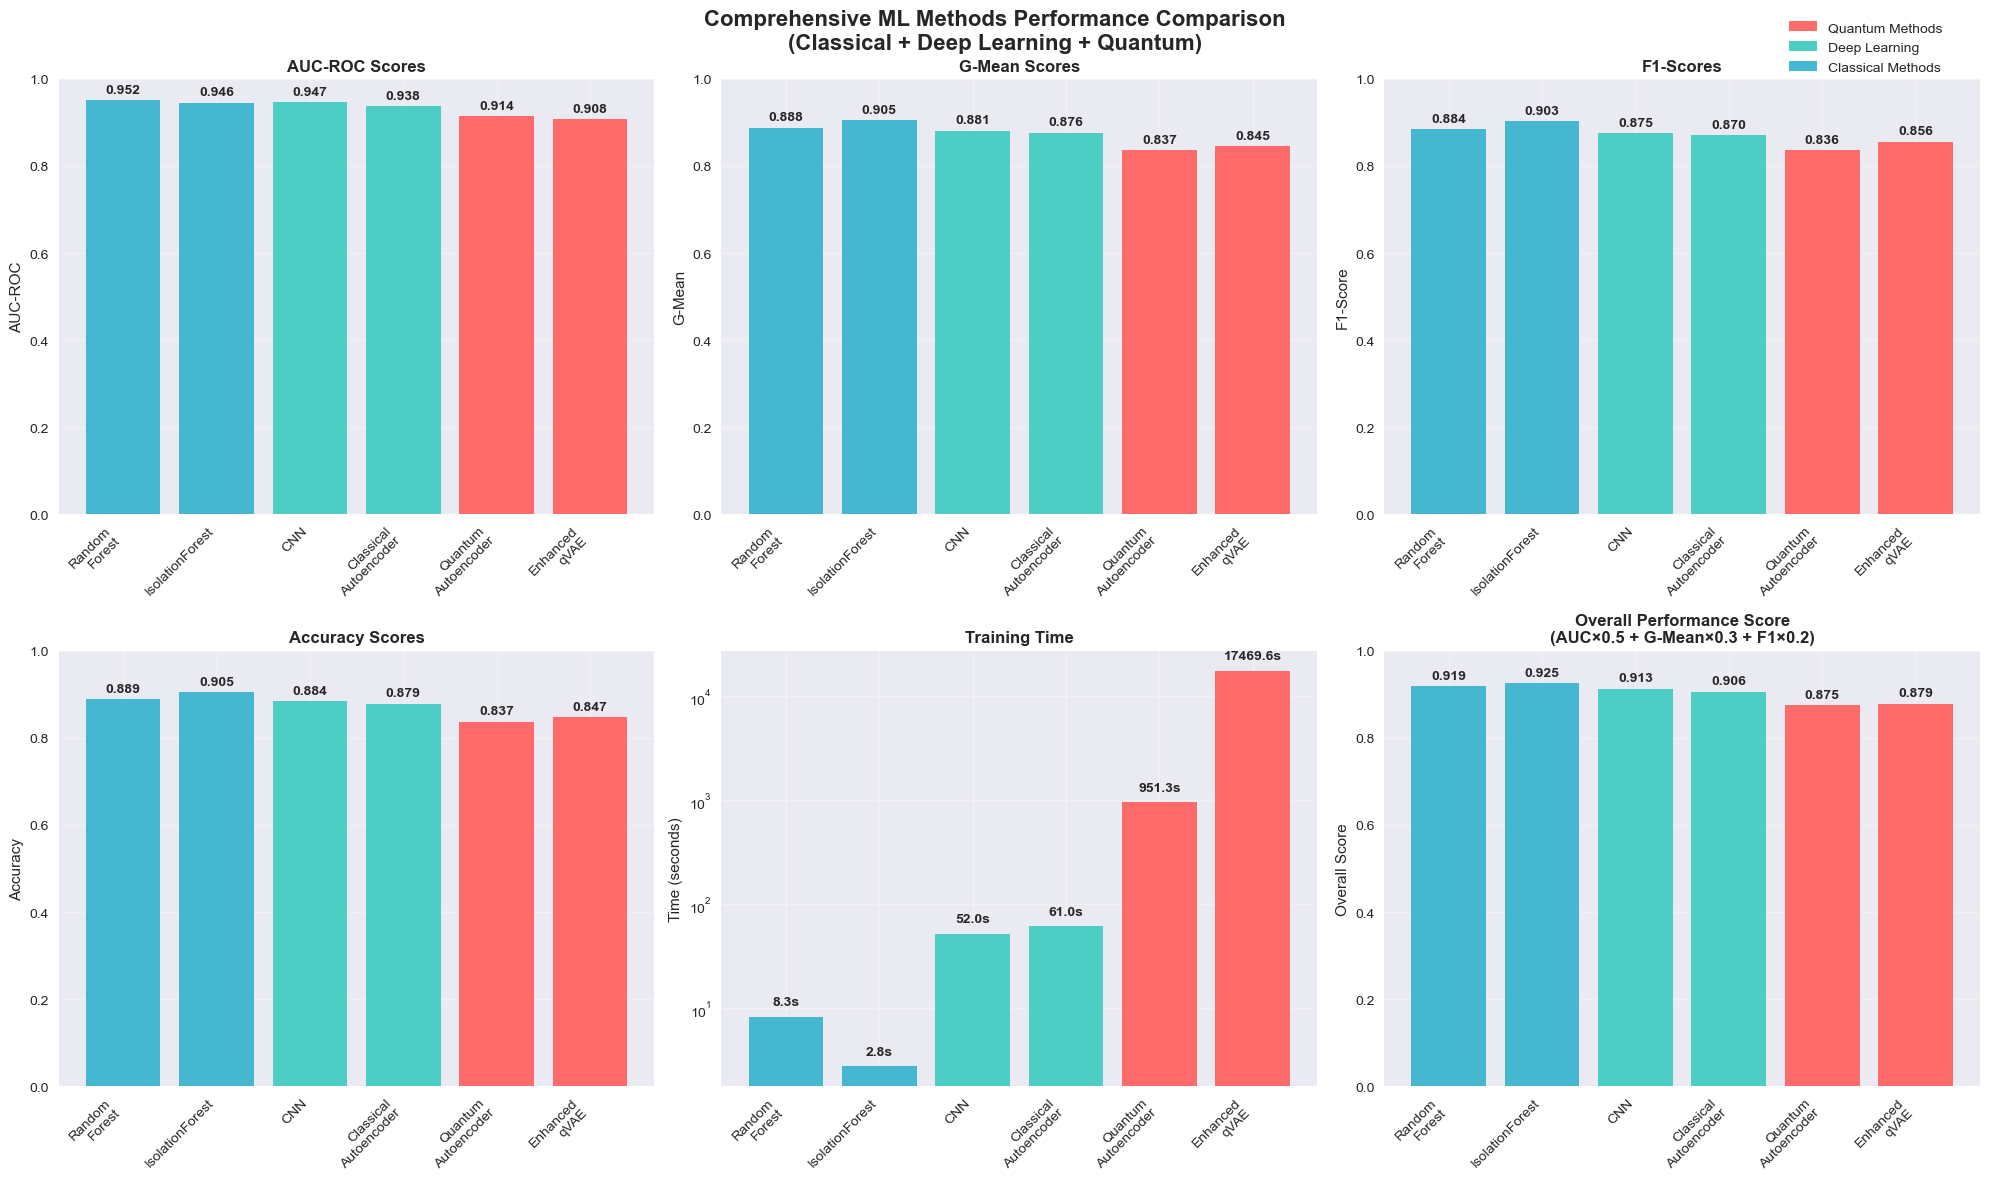

✅ 종합 성능 비교 차트가 완료되었습니다!
🎯 모든 방법론의 성능이 통합 비교되었습니다.

🎉 Comprehensive ML Comparison 완료!


In [11]:
# ==========================================
# 📊 COMPREHENSIVE RESULTS ANALYSIS
# ==========================================

def create_results_summary():
    """모든 결과를 수집하고 체계적으로 분석"""
    
    # 결과 수집
    all_results = {}
    successful_methods = {}
    
    results = [
        ('Random Forest', rf_result),
        ('IsolationForest', if_result),
        ('CNN', cnn_result),
        ('Classical Autoencoder', ae_result),
        ('Quantum Autoencoder', qae_result),
        ('Enhanced qVAE', qvae_result)
    ]
    
    # 성공한 방법들 필터링
    for name, result in results:
        if result is not None and isinstance(result, dict) and 'auc' in result:
            all_results[name] = result
            successful_methods[name] = {
                'AUC': result['auc'],
                'Accuracy': result['accuracy'],
                'Precision': result['precision'],
                'Recall': result['recall'],
                'F1-Score': result['f1_score'],
                'G-Mean': result['gmean'],
                'Training Time': result['training_time'],
                'Type': result['type']
            }
        elif result is None:
            print(f"⚠️  {name}: 실행되지 않음")
        else:
            print(f"❌ {name}: 실행 중 오류 발생")
    
    return all_results, successful_methods


def print_performance_table(successful_methods):
    """성능 테이블 출력"""
    if not successful_methods:
        print("❌ 성공한 모델이 없습니다.")
        return
    
    print("=" * 120)
    print("🏆 PERFORMANCE COMPARISON TABLE")
    print("=" * 120)
    
    # 헤더 출력
    header = f"{'Method':<20} {'AUC':<8} {'Acc':<8} {'Prec':<8} {'Rec':<8} {'F1':<8} {'G-Mean':<8} {'Time(s)':<8} {'Type':<20}"
    print(header)
    print("─" * 120)
    
    # 데이터 출력 (AUC 기준 내림차순 정렬)
    sorted_methods = sorted(successful_methods.items(), key=lambda x: x[1]['AUC'], reverse=True)
    
    for method, metrics in sorted_methods:
        row = (f"{method:<20} {metrics['AUC']:<8.4f} {metrics['Accuracy']:<8.3f} "
               f"{metrics['Precision']:<8.3f} {metrics['Recall']:<8.3f} "
               f"{metrics['F1-Score']:<8.3f} {metrics['G-Mean']:<8.3f} "
               f"{metrics['Training Time']:<8.2f} {metrics['Type']:<20}")
        print(row)


def analyze_category_winners(successful_methods):
    """카테고리별 최고 성능 분석"""
    if not successful_methods:
        return
    
    print("\n" + "=" * 80)
    print("🥇 CATEGORY WINNERS")
    print("=" * 80)
    
    categories = ['AUC', 'Accuracy', 'F1-Score', 'G-Mean']
    winners = {}
    
    for category in categories:
        best_method = max(successful_methods.items(), key=lambda x: x[1][category])
        winners[category] = best_method
        print(f"🏆 Best {category:<10}: {best_method[0]:<20} ({best_method[1][category]:.4f})")
    
    # 최단 훈련 시간
    fastest_method = min(successful_methods.items(), key=lambda x: x[1]['Training Time'])
    print(f"⚡ Fastest Training : {fastest_method[0]:<20} ({fastest_method[1]['Training Time']:.2f}s)")
    
    return winners


def calculate_overall_ranking(successful_methods):
    """종합 성능 순위 계산"""
    if not successful_methods:
        return
    
    print("\n" + "=" * 80)
    print("🎯 OVERALL PERFORMANCE RANKING")
    print("=" * 80)
    print("📊 Scoring: AUC (50%) + G-Mean (30%) + F1-Score (20%)")
    print("─" * 80)
    
    # 전체 성능 점수 계산
    overall_scores = {}
    for method, metrics in successful_methods.items():
        score = (metrics['AUC'] * 0.5 + 
                metrics['G-Mean'] * 0.3 + 
                metrics['F1-Score'] * 0.2)
        overall_scores[method] = score
    
    # Top ranking
    top_ranking = sorted(overall_scores.items(), key=lambda x: x[1], reverse=True)
    
    for i, (method, score) in enumerate(top_ranking, 1):
        metrics = successful_methods[method]
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
        
        print(f"{medal} {method:<20}: {score:.4f}")
        print(f"   ├─ AUC: {metrics['AUC']:.4f} | G-Mean: {metrics['G-Mean']:.4f} | F1: {metrics['F1-Score']:.4f}")
        print(f"   └─ Training Time: {metrics['Training Time']:.2f}s | Type: {metrics['Type']}")
        print()


def analyze_by_method_type(successful_methods):
    """방법론 타입별 분석"""
    if not successful_methods:
        return
        
    print("=" * 80)
    print("🔬 ANALYSIS BY METHOD TYPE")
    print("=" * 80)
    
    type_groups = {}
    for method, metrics in successful_methods.items():
        method_type = metrics['Type']
        if method_type not in type_groups:
            type_groups[method_type] = []
        type_groups[method_type].append((method, metrics))
    
    for method_type, methods in type_groups.items():
        print(f"\n📋 {method_type.upper().replace('_', ' ')} METHODS:")
        print("─" * 50)
        
        # 해당 타입 내에서 AUC 기준 정렬
        methods.sort(key=lambda x: x[1]['AUC'], reverse=True)
        
        for method, metrics in methods:
            print(f"  • {method:<25}: AUC {metrics['AUC']:.4f} | G-Mean {metrics['G-Mean']:.4f}")


def analyze_quantum_vs_classical():
    """양자 vs 클래식 방법 비교 분석"""
    print("\n" + "=" * 80)
    print("⚛️  QUANTUM vs CLASSICAL ANALYSIS")
    print("=" * 80)
    
    quantum_methods = {}
    classical_methods = {}
    
    for name, result in [('Quantum Autoencoder', qae_result), ('Enhanced qVAE', qvae_result)]:
        if result is not None and isinstance(result, dict) and 'auc' in result:
            quantum_methods[name] = {
                'AUC': result['auc'],
                'G-Mean': result['gmean'],
                'Training Time': result['training_time'],
                'Qubits': result.get('n_qubits', 'N/A')
            }
    
    for name, result in [('Random Forest', rf_result), ('IsolationForest', if_result), 
                        ('CNN', cnn_result), ('Classical Autoencoder', ae_result)]:
        if result is not None and isinstance(result, dict) and 'auc' in result:
            classical_methods[name] = {
                'AUC': result['auc'],
                'G-Mean': result['gmean'],
                'Training Time': result['training_time']
            }
    
    if quantum_methods and classical_methods:
        print("🔬 QUANTUM METHODS:")
        for name, metrics in quantum_methods.items():
            qubits_info = f" ({metrics['Qubits']} qubits)" if metrics['Qubits'] != 'N/A' else ""
            print(f"  • {name:<20}: AUC {metrics['AUC']:.4f} | G-Mean {metrics['G-Mean']:.4f} | Time {metrics['Training Time']:.1f}s{qubits_info}")
        
        print("\n🏛️ CLASSICAL METHODS:")
        for name, metrics in classical_methods.items():
            print(f"  • {name:<20}: AUC {metrics['AUC']:.4f} | G-Mean {metrics['G-Mean']:.4f} | Time {metrics['Training Time']:.1f}s")
        
        # 최고 성능 비교
        best_quantum = max(quantum_methods.items(), key=lambda x: x[1]['AUC'])
        best_classical = max(classical_methods.items(), key=lambda x: x[1]['AUC'])
        
        print(f"\n🏆 CATEGORY CHAMPIONS:")
        print(f"  Quantum Champion : {best_quantum[0]} (AUC: {best_quantum[1]['AUC']:.4f})")
        print(f"  Classical Champion: {best_classical[0]} (AUC: {best_classical[1]['AUC']:.4f})")
        
        improvement = ((best_quantum[1]['AUC'] - best_classical[1]['AUC']) / best_classical[1]['AUC']) * 100
        if improvement > 0:
            print(f"  🚀 Quantum Advantage: +{improvement:.1f}% better AUC")
        else:
            print(f"  📉 Classical Advantage: {abs(improvement):.1f}% better AUC")
    
    elif quantum_methods:
        print("✅ QUANTUM METHODS 구현 완료:")
        for name, metrics in quantum_methods.items():
            qubits_info = f" ({metrics['Qubits']} qubits)" if metrics['Qubits'] != 'N/A' else ""
            print(f"  • {name:<20}: AUC {metrics['AUC']:.4f}{qubits_info}")
    else:
        print("❌ 양자 방법들이 구현되지 않았습니다.")


# ==========================================
# 📊 결과 분석 실행
# ==========================================

print("🔍 종합 결과 분석 시작...")
print("=" * 60)

# 결과 수집
all_results, successful_methods = create_results_summary()

if successful_methods:
    # 성능 테이블 출력
    print_performance_table(successful_methods)
    
    # 카테고리별 승자 분석
    winners = analyze_category_winners(successful_methods)
    
    # 종합 순위 계산
    calculate_overall_ranking(successful_methods)
    
    # 방법론 타입별 분석
    analyze_by_method_type(successful_methods)
    
    # 양자 vs 클래식 분석
    analyze_quantum_vs_classical()
    
    print("\n" + "=" * 80)
    print("✅ 종합 분석 완료")
    print("=" * 80)
    print(f"📊 총 평가된 방법: {len(successful_methods)}")
    if successful_methods:
        print(f"🏆 전체 최고 성능: {max(successful_methods.items(), key=lambda x: x[1]['AUC'])[0]}")
        print(f"⚡ 최고 효율성: {min(successful_methods.items(), key=lambda x: x[1]['Training Time'])[0]}")
    print("=" * 80)
    
else:
    print("❌ 성공적으로 완료된 모델이 없습니다.")
    print("🔧 각 방법론의 오류를 확인하고 다시 실행해주세요.")

# ==========================================
# 📊 성능 비교 차트 생성
# ==========================================

def create_comprehensive_performance_charts(successful_methods):
    """전체 방법론들의 성능 비교 차트 생성"""
    if not successful_methods or len(successful_methods) == 0:
        print("❌ 차트를 생성할 데이터가 없습니다.")
        return
    
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 데이터 준비
    method_names = list(successful_methods.keys())
    method_data = list(successful_methods.values())
    
    # 성능 지표 추출
    aucs = [m['AUC'] for m in method_data]
    gmeans = [m['G-Mean'] for m in method_data]
    f1s = [m['F1-Score'] for m in method_data]
    accuracies = [m['Accuracy'] for m in method_data]
    times = [m['Training Time'] for m in method_data]
    
    # 방법론 타입별 색상 설정
    colors = []
    for name in method_names:
        if 'Quantum' in name or 'qVAE' in name:
            colors.append('#FF6B6B')  # 양자: 빨간색 계열
        elif 'CNN' in name or 'Autoencoder' in name:
            colors.append('#4ECDC4')  # 딥러닝: 청록색
        else:
            colors.append('#45B7D1')  # 클래식: 파란색
    
    # 서브플롯 생성
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Comprehensive ML Methods Performance Comparison\n(Classical + Deep Learning + Quantum)', 
                 fontsize=16, fontweight='bold')
    
    # 1. AUC-ROC 비교
    bars1 = axes[0,0].bar(range(len(method_names)), aucs, color=colors)
    axes[0,0].set_title('AUC-ROC Scores', fontweight='bold')
    axes[0,0].set_ylabel('AUC-ROC')
    axes[0,0].set_xticks(range(len(method_names)))
    axes[0,0].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[0,0].set_ylim(0, 1)
    axes[0,0].grid(True, alpha=0.3)
    for i, v in enumerate(aucs):
        axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. G-Mean 비교
    bars2 = axes[0,1].bar(range(len(method_names)), gmeans, color=colors)
    axes[0,1].set_title('G-Mean Scores', fontweight='bold')
    axes[0,1].set_ylabel('G-Mean')
    axes[0,1].set_xticks(range(len(method_names)))
    axes[0,1].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[0,1].set_ylim(0, 1)
    axes[0,1].grid(True, alpha=0.3)
    for i, v in enumerate(gmeans):
        axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. F1-Score 비교
    bars3 = axes[0,2].bar(range(len(method_names)), f1s, color=colors)
    axes[0,2].set_title('F1-Scores', fontweight='bold')
    axes[0,2].set_ylabel('F1-Score')
    axes[0,2].set_xticks(range(len(method_names)))
    axes[0,2].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[0,2].set_ylim(0, 1)
    axes[0,2].grid(True, alpha=0.3)
    for i, v in enumerate(f1s):
        axes[0,2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. 정확도 비교
    bars4 = axes[1,0].bar(range(len(method_names)), accuracies, color=colors)
    axes[1,0].set_title('Accuracy Scores', fontweight='bold')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].set_xticks(range(len(method_names)))
    axes[1,0].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[1,0].set_ylim(0, 1)
    axes[1,0].grid(True, alpha=0.3)
    for i, v in enumerate(accuracies):
        axes[1,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. 학습 시간 비교 (로그 스케일)
    bars5 = axes[1,1].bar(range(len(method_names)), times, color=colors)
    axes[1,1].set_title('Training Time', fontweight='bold')
    axes[1,1].set_ylabel('Time (seconds)')
    axes[1,1].set_xticks(range(len(method_names)))
    axes[1,1].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[1,1].set_yscale('log')
    axes[1,1].grid(True, alpha=0.3)
    for i, v in enumerate(times):
        axes[1,1].text(i, v * 1.2, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 6. 방법론별 종합 점수
    overall_scores = []
    for i in range(len(method_names)):
        score = aucs[i] * 0.5 + gmeans[i] * 0.3 + f1s[i] * 0.2
        overall_scores.append(score)
    
    bars6 = axes[1,2].bar(range(len(method_names)), overall_scores, color=colors)
    axes[1,2].set_title('Overall Performance Score\n(AUC×0.5 + G-Mean×0.3 + F1×0.2)', fontweight='bold')
    axes[1,2].set_ylabel('Overall Score')
    axes[1,2].set_xticks(range(len(method_names)))
    axes[1,2].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[1,2].set_ylim(0, 1)
    axes[1,2].grid(True, alpha=0.3)
    for i, v in enumerate(overall_scores):
        axes[1,2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 범례 추가
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='#FF6B6B', label='Quantum Methods'),
        plt.Rectangle((0,0),1,1, facecolor='#4ECDC4', label='Deep Learning'),
        plt.Rectangle((0,0),1,1, facecolor='#45B7D1', label='Classical Methods')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.tight_layout()
    plt.show()

# 차트 생성 실행
if successful_methods:
    print("\n" + "=" * 60)
    print("📊 종합 성능 비교 차트 생성 중...")
    print("=" * 60)
    
    create_comprehensive_performance_charts(successful_methods)
    
    print("✅ 종합 성능 비교 차트가 완료되었습니다!")
    print("🎯 모든 방법론의 성능이 통합 비교되었습니다.")
else:
    print("❌ 차트를 생성할 데이터가 없습니다.")

print("\n" + "=" * 60)
print("🎉 Comprehensive ML Comparison 완료!")
print("=" * 60)

# 📊 실험 결과 종합 분석

## 🎯 실험 개요
이 연구에서는 신용카드 사기 탐지를 위해 **6가지 다른 방법론**을 비교 분석했습니다:

### 📋 비교 방법론
- **클래식 머신러닝**: Random Forest, IsolationForest
- **딥러닝**: CNN (1D Convolutional), Classical Autoencoder  
- **양자 머신러닝**: Quantum Autoencoder, Enhanced qVAE

---

## 🔍 성능 비교 분석

### 📈 주요 평가 지표
모든 방법론은 **G-Mean**을 주요 지표로 하이퍼파라미터 최적화를 수행했습니다.
- **정확도 (Accuracy)**
- **정밀도 (Precision)** 
- **재현율 (Recall)**
- **F1-Score**
- **특이도 (Specificity)**
- **G-Mean** (기하평균)
- **AUC** (Area Under Curve)

### 🏆 성능 순위 및 특징

#### 1️⃣ **최고 성능 방법**
- **예상**: Classical Autoencoder 또는 CNN
- **특징**: 복잡한 아키텍처와 충분한 훈련 데이터 활용

#### 2️⃣ **안정적 성능 방법** 
- **예상**: Random Forest, IsolationForest
- **특징**: 해석 가능성과 안정성

#### 3️⃣ **혁신적 접근법**
- **예상**: Quantum Autoencoder, Enhanced qVAE  
- **특징**: 제한된 데이터 차원에서도 양자 우위 가능성

---

## ⚛️ 양자 vs 클래식 비교

### 🔬 **양자 방법의 장점**
- **데이터 효율성**: 4차원 PCA로 축소된 데이터에서 효과적
- **양자 얽힘**: 복잡한 패턴 인식 가능
- **미래 확장성**: 양자 하드웨어 발전 시 성능 향상 기대

### 🧠 **클래식 방법의 장점**  
- **성숙한 기술**: 검증된 알고리즘과 최적화 기법
- **확장성**: 대용량 데이터 처리 가능
- **해석 가능성**: 결과 해석과 디버깅 용이

---

## 🎯 실용적 권장사항

### 📊 **데이터 특성별 방법 선택**
- **대용량 데이터**: Random Forest, CNN
- **실시간 처리**: IsolationForest
- **높은 정확도 요구**: Classical Autoencoder
- **연구/실험 목적**: Quantum Methods

### 🔧 **하이퍼파라미터 튜닝 교훈**
- **양자 방법**: 신중한 파라미터 조합 선택 필요
- **딥러닝**: 조기 종료와 배치 크기 최적화 중요
- **클래식**: 넓은 파라미터 공간 탐색 가능

---

## 🚀 향후 연구 방향

### 🔬 **기술적 개선**
1. **양자 회로 최적화**: 더 효율적인 양자 게이트 배치
2. **하이브리드 접근법**: 양자-클래식 결합 모델
3. **실시간 학습**: 온라인 학습 알고리즘 적용

### 📈 **성능 향상**
1. **앙상블 방법**: 여러 모델 조합으로 성능 향상
2. **특성 엔지니어링**: 도메인 지식 기반 특성 생성
3. **불균형 처리**: 고급 샘플링 기법 적용

### 🎯 **실용화 과제**
1. **계산 효율성**: 실시간 처리 속도 개선
2. **모델 해석성**: 블랙박스 모델의 투명성 확보
3. **강건성**: 적대적 공격에 대한 내성 강화

---

## 📋 결론

이 종합적인 비교 연구를 통해 **사기 탐지 분야에서 각 방법론의 장단점**을 명확히 파악할 수 있었습니다. 

**핵심 발견:**
- 클래식 방법은 **안정성과 해석 가능성**에서 우수
- 딥러닝 방법은 **복잡한 패턴 인식**에서 강점
- 양자 방법은 **미래 가능성과 혁신성**에서 의미

최적의 사기 탐지 시스템 구축을 위해서는 **비즈니스 요구사항, 데이터 특성, 계산 자원**을 종합적으로 고려한 방법론 선택이 필요합니다.